# 前段環境設置

(資料、路徑、檔案解壓縮...)

## google drive 連結

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 資料解壓縮

In [ ]:
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/104_HOUR_00_20160323.zip"
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/105_HOUR_00_20170301.zip"
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/106_HOUR_00_20180308.zip"
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/雲嘉南空品區_2018.zip"
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/雲嘉南空品區_2019.zip"
!unzip -O big5 "/content/drive/MyDrive/lab/pm2.5_predictions/雲嘉南空品區_2020.zip"

Archive:  /content/drive/MyDrive/lab/pm2.5_predictions/104_HOUR_00_20160323.zip
   creating: 104_HOUR_00_20160323/
   creating: 104_HOUR_00_20160323/104年 中部空品區/
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年二林站_20160318.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年二林站_20160318.xls  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年南投站_20160318.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年南投站_20160318.xls  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年埔里站_20160323.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年埔里站_20160323.xls  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年大里站_20160318.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年大里站_20160318.xls  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年彰化站_20160318.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年彰化站_20160318.xls  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年忠明站_20160318.ods  
  inflating: 104_HOUR_00_20160323/104年 中部空品區/104年忠明站_20160318.xls  
  inflating: 104_HOUR_0

In [ ]:
### 修改 folder，方便後續程式運作
!mv "/content/104_HOUR_00_20160323" "/content/104_HOUR_00_20160323_南"

## 資料選取 loop through 資料夾抓取 - 台南監測資料

In [ ]:
### 建立存放分析數據的資料夾
import os

my_data = "/content/data"

if os.path.exists(my_data):
  None
else:
  os.mkdir(my_data)

In [ ]:
### 撰寫函數

def extract_file(f_path):
  for data_path in os.listdir(f_path):
    full_path = f_path + "/" + data_path
    if "南" in full_path:
      # print(full_path)
      if os.path.isdir(full_path):
        extract_file(full_path)
      else:
        if ("臺南" in full_path) & (("csv" in full_path) or ("xls" in full_path)):
          os.rename(full_path, "./data/" + data_path)

extract_file(".")


## 讀取檔案

In [ ]:
import pandas as pd

tn_2015 = pd.read_excel("/content/data/104年臺南站_20160320.xls")
tn_2016 = pd.read_excel("/content/data/105年臺南站_20170217.xls")
tn_2017 = pd.read_excel("/content/data/106年臺南站_20180309.xls")
tn_2018 = pd.read_csv("/content/data/臺南_2018.csv",encoding = "big5")
tn_2019 = pd.read_csv("/content/data/臺南_2019.csv",encoding = "big5")
tn_2020 = pd.read_csv("/content/data/臺南_2020.csv",encoding = "big5")

# 資料格式


## 2018年 - 2020年 資料清理 

(csv檔中，欄位及資料中有許多空格)

In [ ]:
tn_2018 = tn_2018.drop(index=[0]).reset_index(drop=True)
tn_2019 = tn_2019.drop(index=[0]).reset_index(drop=True)
tn_2020 = tn_2020.drop(index=[0]).reset_index(drop=True)

tn_2018 = tn_2018.replace("00:00:00", "", regex=True)
tn_2019 = tn_2019.replace("00:00:00", "", regex=True)
tn_2020 = tn_2020.replace("00:00:00", "", regex=True)

tn_2018 = tn_2018.replace(" ", "", regex=True)
tn_2019 = tn_2019.replace(" ", "", regex=True)
tn_2020 = tn_2020.replace(" ", "", regex=True)

for i in tn_2018.columns:
  tn_2018 = tn_2018.rename(columns={i:i.replace(" ","")})
for i in tn_2019.columns:
  tn_2019 = tn_2019.rename(columns={i:i.replace(" ","")})
for i in tn_2020.columns:
  tn_2020 = tn_2020.rename(columns={i:i.replace(" ","")})

## 2015年 - 2020年 資料格式調整

 → 調整為可作分析用之格式

In [ ]:
def data_transform(data_set):

  col_list = ['日期','測站',"timing","AMB_TEMP","CH4","CO","NMHC","NO","NO2","NOx","O3","PM10","PM2.5","RAINFALL","RH","SO2","THC","WD_HR","WIND_DIREC","WIND_SPEED","WS_HR"]
  df_all = pd.DataFrame(columns=col_list)
  df_new = None
  
  for i in range(len(data_set)):
    d = {str(data_set.columns[0]): data_set.loc[i].values[0],
         str(data_set.columns[1]): data_set.loc[i].values[1],
         'timing': data_set.loc[i][3:].index,
         str(data_set.loc[i].values[2]): data_set.loc[i][3:].values
         }
    df_temp = pd.DataFrame(data=d)
  
    if i % 18 == 0:
      if df_new is not None:
        df_all = pd.concat([df_all[col_list], df_new[col_list]])
      df_new = df_temp
    else: 
      df_new = df_new.merge(df_temp, how="outer",on=[str(data_set.columns[0]),"timing",str(data_set.columns[1])])
  
  df_all = pd.concat([df_all[col_list], df_new[col_list]])
  
  return df_all

In [ ]:
tn_2015_new = data_transform(tn_2015)
tn_2016_new = data_transform(tn_2016)
tn_2017_new = data_transform(tn_2017)
tn_2018_new = data_transform(tn_2018)
tn_2019_new = data_transform(tn_2019)
tn_2020_new = data_transform(tn_2020)

tn_2018_new.head(5)

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2018/01/01,臺南,00,15.7,2,0.65,0.15,2,16.4,18.4,17,71,50,0,78,2,2.1,22,30,2.6,2.4
1,2018/01/01,臺南,01,15.6,2,0.6,0.14,1.9,16,17.8,16.9,74,50,0,78,2.3,2.1,18,16,2,2
2,2018/01/01,臺南,02,15.4,2,0.55,0.12,1.9,14.7,16.7,18.3,62,43,0,78,2,2.1,14,18,2.3,1.9
3,2018/01/01,臺南,03,15.4,2,0.49,0.11,1.6,13.1,14.6,19.1,58,41,0,78,2.2,2.1,17,10,2.7,1.9
4,2018/01/01,臺南,04,15.4,2,0.5,0.11,1.5,15,16.5,16.7,56,34,0,78,2.3,2.1,26,25,2.5,1.8


## 整併為一份 dataset

In [ ]:
col_list = ['日期','測站',"timing","AMB_TEMP","CH4","CO","NMHC","NO","NO2","NOx","O3","PM10","PM2.5","RAINFALL","RH","SO2","THC","WD_HR","WIND_DIREC","WIND_SPEED","WS_HR"]

tn_dataset = pd.concat([tn_2015_new[col_list], tn_2016_new[col_list]])
tn_dataset = pd.concat([tn_dataset[col_list], tn_2017_new[col_list]])
tn_dataset = pd.concat([tn_dataset[col_list], tn_2018_new[col_list]])
tn_dataset = pd.concat([tn_dataset[col_list], tn_2019_new[col_list]])
tn_dataset = pd.concat([tn_dataset[col_list], tn_2020_new[col_list]])
tn_dataset

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2015/01/01,臺南,00,16,2.1,1.26,0.48,9.7,46,55,2,102,59,NR,82,4.8,2.5,93,84,0.6,0.6
1,2015/01/01,臺南,01,16,2.1,1.28,0.48,15,42,58,1.9,100,64,NR,82,4.8,2.6,15,336,0.9,0.5
2,2015/01/01,臺南,02,15,2.1,0.88,0.3,15,36,51,4.6,99,65,NR,84,3.8,2.4,3.9,61,0.5,0.5
3,2015/01/01,臺南,03,15,2,0.63,0.21,1.3,27,28,13,94,57,NR,77,6.1,2.2,59,70,1.6,1.2
4,2015/01/01,臺南,04,15,2,0.61,0.25,1.5,32,34,7.7,88,54,NR,75,6.2,2.3,72,66,1.5,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2020/12/31,臺南,19,12.4,1.98,0.44,0.17,2.7,24.2,26.9,9.4,53,33,0,63,2.1,2.14,15,21,3.3,2.8
20,2020/12/31,臺南,20,12.1,1.97,0.43,0.15,2.5,21.6,24.1,10.4,47,27,0,64,1.9,2.13,14,12,3,2.8
21,2020/12/31,臺南,21,11.9,1.97,0.45,0.15,2.3,21.2,23.5,10,44,27,0,65,1.9,2.12,19,23,2.8,2.7
22,2020/12/31,臺南,22,11.7,1.99,0.4,0.14,2,20,22,10.5,38,25,0,66,1.8,2.12,23,16,2.8,2.7


## 資料清理 (數值格式)

 → 字串轉數值

In [ ]:
tn_dataset_cleaned = tn_dataset.replace("#", "", regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("\*", "", regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("NR", 0, regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("x", "", regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("NA", np.nan, regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("A", "", regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("N", "", regex=True)
tn_dataset_cleaned = tn_dataset_cleaned.reset_index(drop=True)
tn_dataset_cleaned = tn_dataset_cleaned.replace("", np.nan, regex=True)
tn_dataset_cleaned.head(5)

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2015/01/01,臺南,00,16,2.1,1.26,0.48,9.7,46,55,2,102,59,0,82,4.8,2.5,93,84,0.6,0.6
1,2015/01/01,臺南,01,16,2.1,1.28,0.48,15,42,58,1.9,100,64,0,82,4.8,2.6,15,336,0.9,0.5
2,2015/01/01,臺南,02,15,2.1,0.88,0.3,15,36,51,4.6,99,65,0,84,3.8,2.4,3.9,61,0.5,0.5
3,2015/01/01,臺南,03,15,2,0.63,0.21,1.3,27,28,13,94,57,0,77,6.1,2.2,59,70,1.6,1.2
4,2015/01/01,臺南,04,15,2,0.61,0.25,1.5,32,34,7.7,88,54,0,75,6.2,2.3,72,66,1.5,1.8


In [ ]:
tn_dataset_cleaned["timing"] = tn_dataset_cleaned["timing"].astype("int8")
tn_dataset_cleaned["AMB_TEMP"] = tn_dataset_cleaned["AMB_TEMP"].astype("float32")
tn_dataset_cleaned["CH4"] = tn_dataset_cleaned["CH4"].astype("float32")
tn_dataset_cleaned["CO"] = tn_dataset_cleaned["CO"].astype("float32")
tn_dataset_cleaned["NMHC"] = tn_dataset_cleaned["NMHC"].astype("float32")
tn_dataset_cleaned["NO"] = tn_dataset_cleaned["NO"].astype("float32")
tn_dataset_cleaned["NO2"] = tn_dataset_cleaned["NO2"].astype("float32")
tn_dataset_cleaned["NOx"] = tn_dataset_cleaned["NOx"].astype("float32")
tn_dataset_cleaned["O3"] = tn_dataset_cleaned["O3"].astype("float32")
tn_dataset_cleaned["PM10"] = tn_dataset_cleaned["PM10"].astype("float32")
tn_dataset_cleaned["PM2.5"] = tn_dataset_cleaned["PM2.5"].astype("float32")
tn_dataset_cleaned["RAINFALL"] = tn_dataset_cleaned["RAINFALL"].astype("float32")
tn_dataset_cleaned["RH"] = tn_dataset_cleaned["RH"].astype("float32")
tn_dataset_cleaned["SO2"] = tn_dataset_cleaned["SO2"].astype("float32")
tn_dataset_cleaned["THC"] = tn_dataset_cleaned["THC"].astype("float32")
tn_dataset_cleaned["WD_HR"] = tn_dataset_cleaned["WD_HR"].astype("float32")
tn_dataset_cleaned["WIND_DIREC"] = tn_dataset_cleaned["WIND_DIREC"].astype("float32")
tn_dataset_cleaned["WIND_SPEED"] = tn_dataset_cleaned["WIND_SPEED"].astype("float32")
tn_dataset_cleaned["WS_HR"] = tn_dataset_cleaned["WS_HR"].astype("float32")

tn_dataset_cleaned.head(5)

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2015/01/01,臺南,0,16.0,2.1,1.26,0.48,9.7,46.0,55.0,2.0,102.0,59.0,0.0,82.0,4.8,2.5,93.0,84.0,0.6,0.6
1,2015/01/01,臺南,1,16.0,2.1,1.28,0.48,15.0,42.0,58.0,1.9,100.0,64.0,0.0,82.0,4.8,2.6,15.0,336.0,0.9,0.5
2,2015/01/01,臺南,2,15.0,2.1,0.88,0.30,15.0,36.0,51.0,4.6,99.0,65.0,0.0,84.0,3.8,2.4,3.9,61.0,0.5,0.5
3,2015/01/01,臺南,3,15.0,2.0,0.63,0.21,1.3,27.0,28.0,13.0,94.0,57.0,0.0,77.0,6.1,2.2,59.0,70.0,1.6,1.2
4,2015/01/01,臺南,4,15.0,2.0,0.61,0.25,1.5,32.0,34.0,7.7,88.0,54.0,0.0,75.0,6.2,2.3,72.0,66.0,1.5,1.8


## 遺失值處理

→ 針對 nan 值使用前後時間平均值


In [ ]:
tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["AMB_TEMP","CH4","CO","NMHC","NO","NO2","NOx","O3","PM10","PM2.5","RAINFALL","RH","SO2","THC","WD_HR","WIND_DIREC","WIND_SPEED","WS_HR"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

In [ ]:
tn_dataset_cleaned.corr()

,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
timing,1.000000,0.125944,-0.219915,0.090908,-0.014604,-0.056702,-0.008828,-0.034789,0.239466,0.024106,-0.011590,-0.007224,-0.185019,-0.049703,-0.122443,0.170977,0.141235,0.134317,0.072608
AMB_TEMP,0.125944,1.000000,-0.341934,-0.473871,-0.097289,-0.092412,-0.480914,-0.459238,0.218348,-0.140903,-0.080117,0.005754,-0.235562,-0.011219,-0.252623,0.527579,0.497591,-0.034709,0.036240
CH4,-0.219915,-0.341934,1.000000,0.433381,0.164351,0.120362,0.406155,0.408556,-0.113004,0.152616,0.085040,-0.058355,0.163667,0.100687,0.538726,-0.291344,-0.259089,-0.213592,-0.121902
CO,0.090908,-0.473871,0.433381,1.000000,0.230462,0.275320,0.686422,0.719425,-0.022772,0.216130,0.131392,-0.077869,0.022351,0.181283,0.412489,-0.267033,-0.238742,-0.179944,-0.177305
NMHC,-0.014604,-0.097289,0.164351,0.230462,1.000000,0.091283,0.211572,0.224840,-0.035787,0.058650,0.031802,-0.019423,0.041397,0.047236,0.890107,-0.075844,-0.072077,-0.099915,-0.062657
NO,-0.056702,-0.092412,0.120362,0.275320,0.091283,1.000000,0.544501,0.665325,-0.122716,0.053697,0.038883,-0.004214,0.034194,0.072858,0.138538,-0.068620,-0.045519,-0.031281,-0.019759
NO2,-0.008828,-0.480914,0.406155,0.686422,0.211572,0.544501,1.000000,0.958445,-0.227599,0.170315,0.106766,-0.058531,0.138401,0.145595,0.383168,-0.342142,-0.309951,-0.236419,-0.170342
NOx,-0.034789,-0.459238,0.408556,0.719425,0.224840,0.665325,0.958445,1.000000,-0.256209,0.161761,0.102578,-0.054178,0.137749,0.159165,0.395786,-0.329614,-0.291529,-0.220465,-0.157741
O3,0.239466,0.218348,-0.113004,-0.022772,-0.035787,-0.122716,-0.227599,-0.256209,1.000000,0.134041,0.064788,-0.031431,-0.565531,0.014534,-0.087206,0.397386,0.364595,0.269022,0.100284
PM10,0.024106,-0.140903,0.152616,0.216130,0.058650,0.053697,0.170315,0.161761,0.134041,1.000000,0.263128,-0.035626,-0.095830,0.117617,0.112873,-0.038723,-0.037096,0.031098,0.001778


# 資料視覺化


In [ ]:
tn_dataset_cleaned

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,2015/01/01,臺南,0,16.0,2.10,1.26,0.48,9.7,46.000000,55.000000,2.0,102.0,59.0,0.0,82.0,4.8,2.50,93.0,84.0,0.6,0.6
1,2015/01/01,臺南,1,16.0,2.10,1.28,0.48,15.0,42.000000,58.000000,1.9,100.0,64.0,0.0,82.0,4.8,2.60,15.0,336.0,0.9,0.5
2,2015/01/01,臺南,2,15.0,2.10,0.88,0.30,15.0,36.000000,51.000000,4.6,99.0,65.0,0.0,84.0,3.8,2.40,3.9,61.0,0.5,0.5
3,2015/01/01,臺南,3,15.0,2.00,0.63,0.21,1.3,27.000000,28.000000,13.0,94.0,57.0,0.0,77.0,6.1,2.20,59.0,70.0,1.6,1.2
4,2015/01/01,臺南,4,15.0,2.00,0.61,0.25,1.5,32.000000,34.000000,7.7,88.0,54.0,0.0,75.0,6.2,2.30,72.0,66.0,1.5,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52603,2020/12/31,臺南,19,12.4,1.98,0.44,0.17,2.7,24.200001,26.900000,9.4,53.0,33.0,0.0,63.0,2.1,2.14,15.0,21.0,3.3,2.8
52604,2020/12/31,臺南,20,12.1,1.97,0.43,0.15,2.5,21.600000,24.100000,10.4,47.0,27.0,0.0,64.0,1.9,2.13,14.0,12.0,3.0,2.8
52605,2020/12/31,臺南,21,11.9,1.97,0.45,0.15,2.3,21.200001,23.500000,10.0,44.0,27.0,0.0,65.0,1.9,2.12,19.0,23.0,2.8,2.7
52606,2020/12/31,臺南,22,11.7,1.99,0.40,0.14,2.0,20.000000,22.000000,10.5,38.0,25.0,0.0,66.0,1.8,2.12,23.0,16.0,2.8,2.7


## 氣溫數據檢視與處理

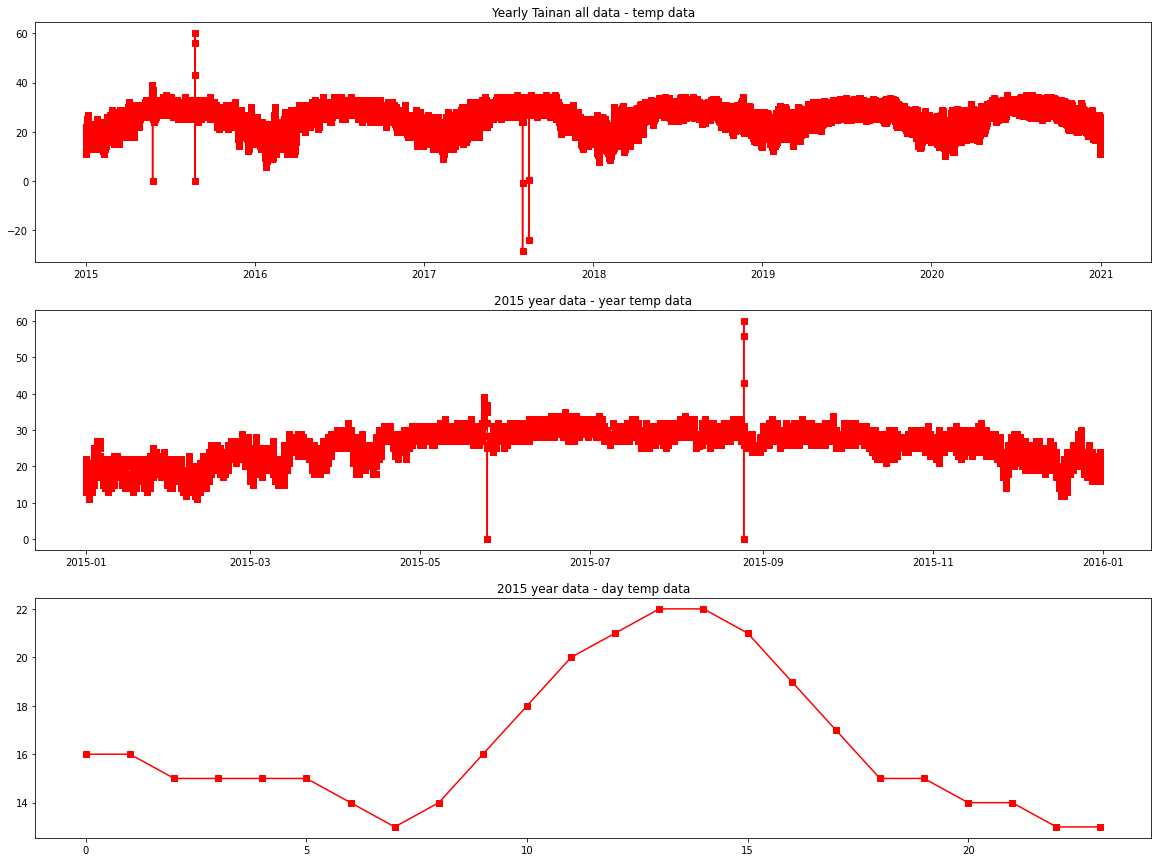

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - temp data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["AMB_TEMP"],'s-',color = 'r')

axs[1].title.set_text('2015 year data - year temp data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["AMB_TEMP"][:365*24],'s-',color = 'r')

axs[2].title.set_text('2015 year data - day temp data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["AMB_TEMP"][:24],'s-',color = 'r')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["AMB_TEMP"] > 40]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
5673,2015/08/25,臺南,9,60.0,2.0,0.51,0.18,2.5,15.0,18.0,28.0,18.0,12.0,0.0,89.0,1.6,2.2,143.0,146.0,2.8,1.9
5674,2015/08/25,臺南,10,56.0,2.0,0.41,0.13,3.2,11.0,14.0,22.0,15.0,12.0,0.0,85.0,1.2,2.1,141.0,135.0,2.6,2.3
5675,2015/08/25,臺南,11,43.0,1.9,0.34,0.11,2.8,7.0,9.9,36.0,17.0,10.0,0.2,77.0,1.3,2.1,139.0,138.0,3.1,2.9


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["AMB_TEMP"] < 1]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
3466,2015/05/25,臺南,10,0.0,1.80,0.330,0.08,0.7,6.4,7.1,40.0,15.0,3.0,0.2,87.0,1.50,1.8,225.000000,229.000000,2.10,1.5
3467,2015/05/25,臺南,11,0.0,1.80,0.340,0.08,0.3,5.7,6.1,41.0,10.0,7.0,0.0,86.0,1.40,1.8,225.000000,226.000000,2.00,2.0
3468,2015/05/25,臺南,12,0.0,1.80,0.350,0.08,0.9,8.5,9.3,38.0,10.0,3.0,0.2,88.0,1.90,1.8,217.000000,227.000000,2.30,1.7
3469,2015/05/25,臺南,13,0.0,1.80,0.270,0.05,0.4,4.9,5.3,44.0,14.0,1.0,0.6,89.0,1.30,1.8,223.000000,228.000000,2.40,2.9
5671,2015/08/25,臺南,7,0.0,2.00,0.470,0.13,1.3,11.0,13.0,27.0,24.0,13.0,0.4,92.0,2.60,2.1,115.000000,119.000000,1.10,2.4
5672,2015/08/25,臺南,8,0.0,2.00,0.690,0.21,1.2,16.0,17.0,29.0,14.0,19.0,0.2,91.0,1.90,2.2,171.000000,153.000000,1.90,1.1
22644,2017/08/01,臺南,12,-0.8,1.75,0.355,0.21,3.5,15.0,18.5,13.5,19.0,8.0,6.5,45.0,1.85,2.0,65.050003,80.400002,1.45,0.5
22645,2017/08/01,臺南,13,-0.8,1.75,0.355,0.21,3.5,15.0,18.5,13.5,19.0,8.0,6.5,45.0,1.85,2.0,65.050003,80.400002,1.45,0.5
22646,2017/08/01,臺南,14,-28.6,1.80,0.290,0.19,3.3,15.0,18.0,12.0,15.0,3.0,8.4,1.0,1.70,2.0,7.100000,4.800000,0.60,0.1
22986,2017/08/15,臺南,18,-23.9,1.60,0.160,0.05,1.3,4.7,6.0,17.0,14.5,10.5,0.0,9.4,2.10,1.7,252.000000,252.000000,1.70,1.5


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["AMB_TEMP"] > 40, "AMB_TEMP"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["AMB_TEMP"] < 1, "AMB_TEMP"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["AMB_TEMP"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

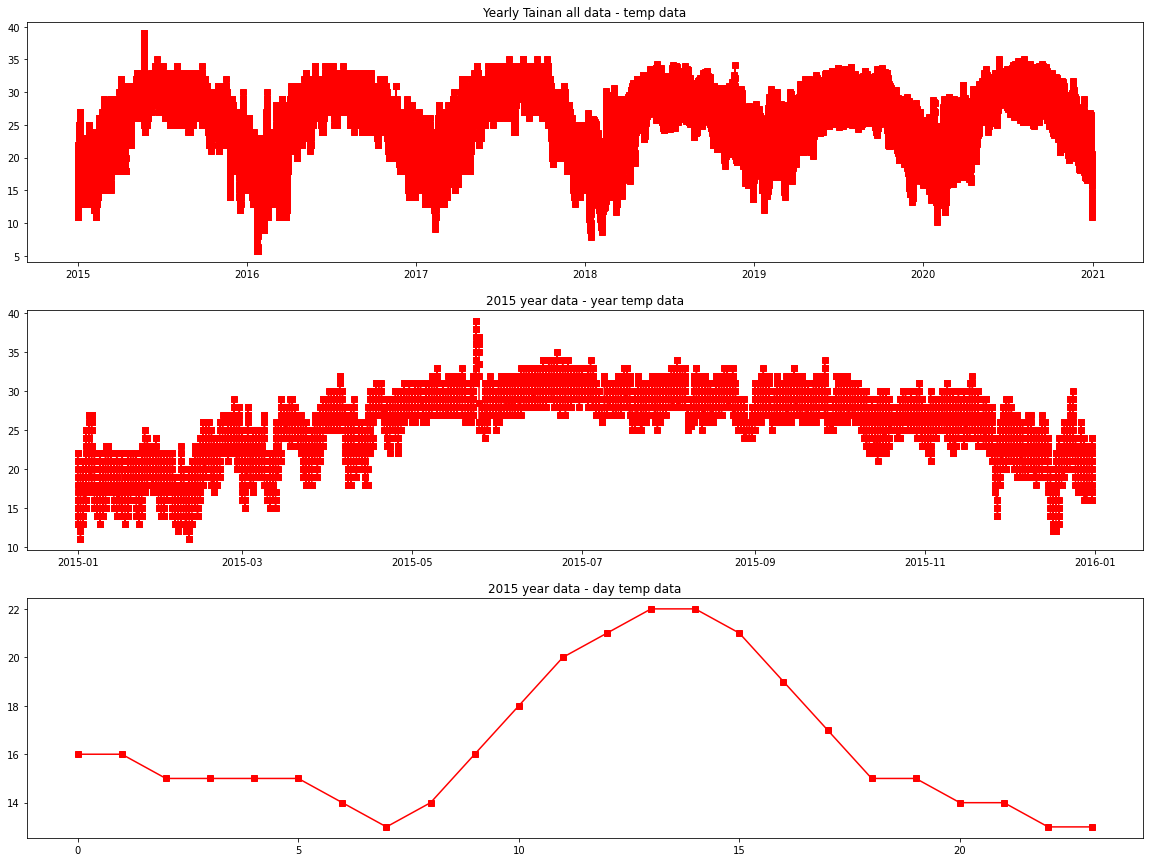

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - temp data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["AMB_TEMP"],'s-',color = 'r')

axs[1].title.set_text('2015 year data - year temp data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["AMB_TEMP"][:365*24],'s-',color = 'r')

axs[2].title.set_text('2015 year data - day temp data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["AMB_TEMP"][:24],'s-',color = 'r')

## CH4 數據檢視與處理

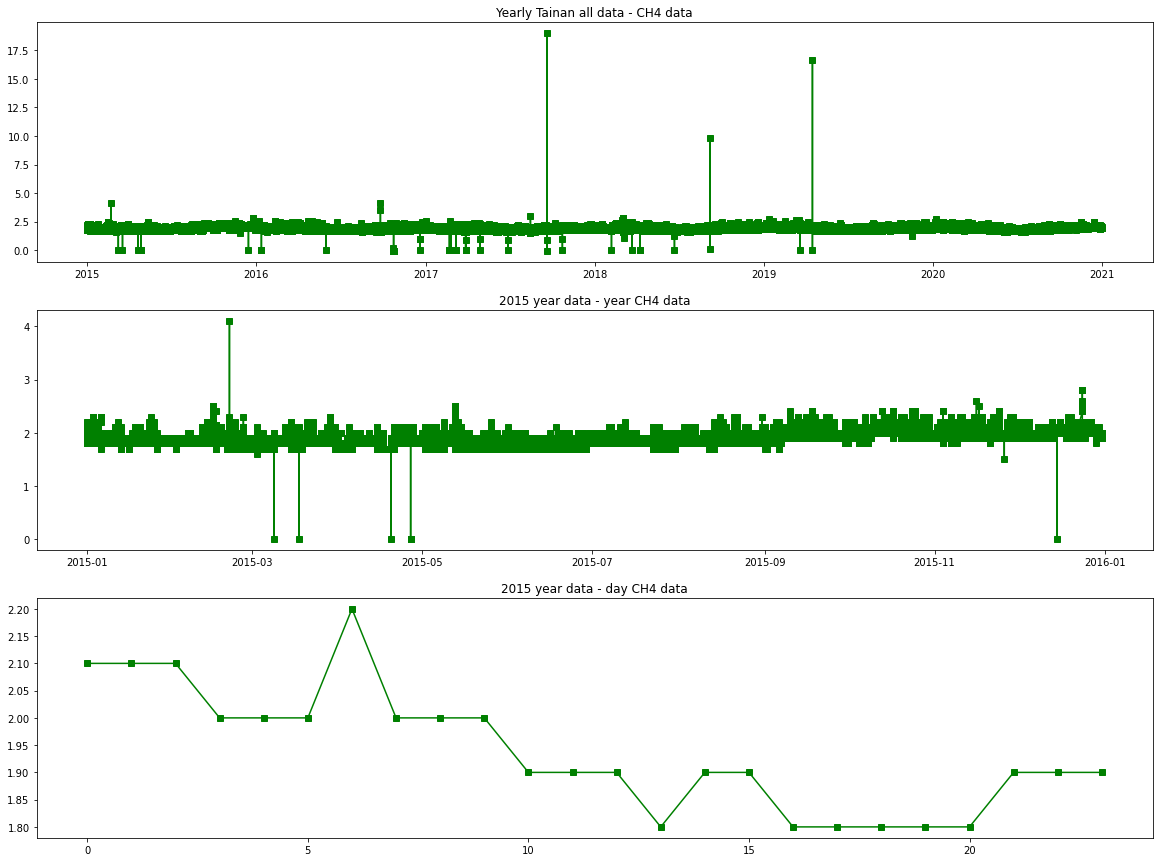

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - CH4 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["CH4"],'s-',color = 'g')

axs[1].title.set_text('2015 year data - year CH4 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["CH4"][:365*24],'s-',color = 'g')

axs[2].title.set_text('2015 year data - day CH4 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["CH4"][:24],'s-',color = 'g')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["CH4"] > 5]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
23845,2017/09/20,臺南,13,35.000000,19.00,0.38,0.07,0.05,4.3,4.3,42.0,49.0,25.0,0.0,44.0,1.85,19.00,322.0,328.0,3.4,2.9
32293,2018/09/07,臺南,13,31.700001,9.80,0.16,8.12,3.00,2.8,5.7,61.5,40.0,26.0,0.0,74.0,0.50,9.90,247.0,247.0,3.5,3.1
37596,2019/04/16,臺南,12,24.700001,16.66,0.51,16.73,3.10,17.4,20.5,0.0,1000.0,33.0,0.0,82.0,2.50,16.73,344.0,347.0,1.9,1.6


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["CH4"] < 1]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
1619,2015/03/09,臺南,11,26.0,0.00,0.420,0.115000,2.6,11.00,13.00,0.000000,59.0,32.0,0.0,62.0,2.30,0.000000,42.0,45.0,4.6,1.20
1836,2015/03/18,臺南,12,28.0,0.00,0.310,0.095000,2.3,14.00,16.00,47.000000,58.0,21.0,0.0,50.0,6.20,0.000000,205.0,209.0,4.0,3.70
2630,2015/04/20,臺南,14,30.0,0.00,0.240,0.080000,1.0,4.10,5.10,25.000000,44.0,28.0,0.0,56.0,0.50,1.700000,231.0,222.0,2.5,2.00
2796,2015/04/27,臺南,12,30.0,0.00,0.205,0.090000,0.7,6.75,3.95,34.000000,66.0,37.0,0.0,49.0,2.25,0.000000,286.0,277.0,3.1,2.25
2797,2015/04/27,臺南,13,30.0,0.00,0.205,0.090000,0.7,6.75,3.95,34.000000,58.0,31.0,0.0,49.0,2.25,0.000000,286.0,282.0,3.2,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28669,2018/04/09,臺南,13,26.0,0.00,0.280,0.000000,2.2,4.80,7.00,69.000000,40.0,4.0,0.0,48.0,2.00,0.000000,275.0,279.0,3.5,3.10
30444,2018/06/22,臺南,12,29.5,0.00,0.180,28.870001,2.7,3.90,6.60,27.700001,31.0,5.0,0.0,81.0,1.90,30.500000,216.0,215.0,3.8,2.90
32294,2018/09/07,臺南,14,31.5,0.10,0.200,40.450001,3.1,3.60,6.70,33.400002,37.0,25.0,0.0,74.0,1.40,40.500000,251.0,253.0,3.0,3.00
36949,2019/03/20,臺南,13,28.5,0.01,0.270,0.000000,1.7,6.40,8.10,62.299999,47.0,23.0,0.0,68.0,2.60,0.010000,212.0,217.0,4.0,2.60


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["CH4"] > 5, "CH4"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["CH4"] < 1, "CH4"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["CH4"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

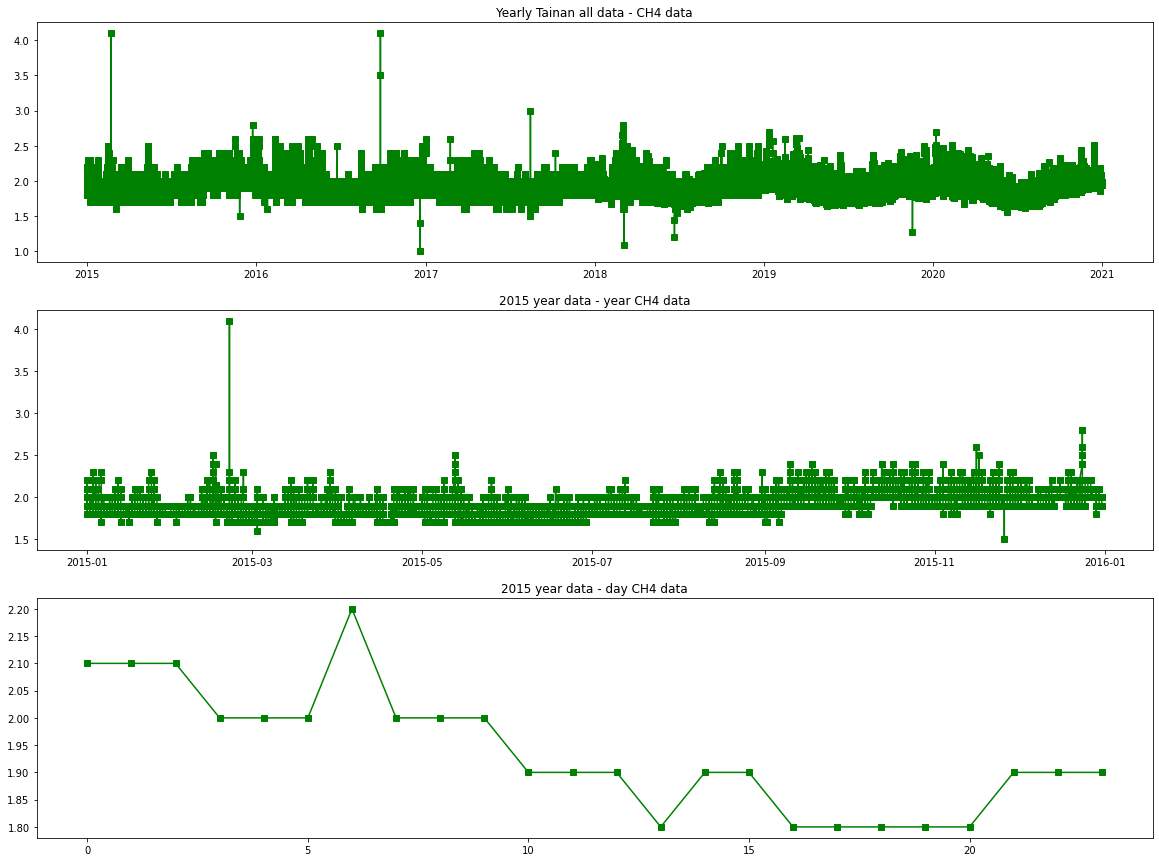

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - CH4 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["CH4"],'s-',color = 'g')

axs[1].title.set_text('2015 year data - year CH4 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["CH4"][:365*24],'s-',color = 'g')

axs[2].title.set_text('2015 year data - day CH4 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["CH4"][:24],'s-',color = 'g')

## CO 數據檢視與處理

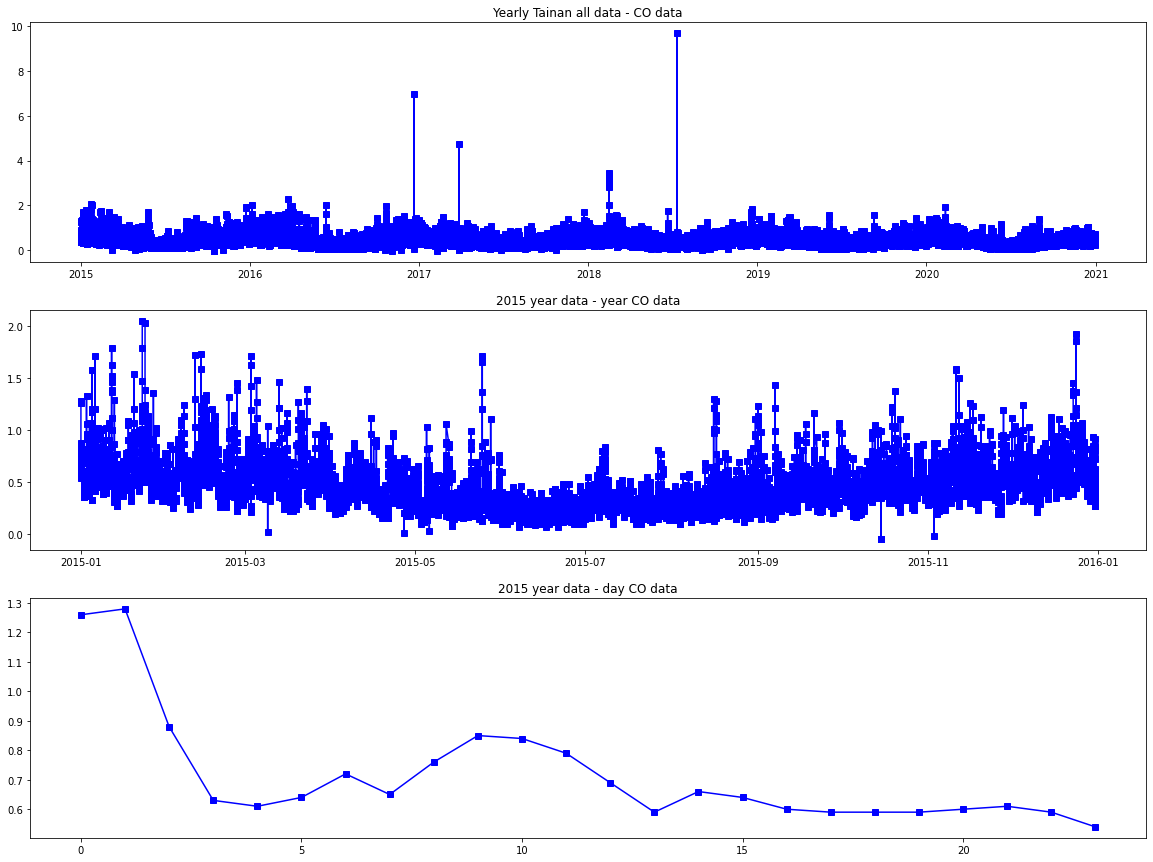

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - CO data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["CO"],'s-',color = 'b')

axs[1].title.set_text('2015 year data - year CO data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["CO"][:365*24],'s-',color = 'b')

axs[2].title.set_text('2015 year data - day CO data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["CO"][:24],'s-',color = 'b')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["CO"] > 5]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
17270,2016/12/20,臺南,14,26.0,1.8,6.99,0.20,-0.200000,26.0,26.000000,48.0,84.0,63.0,0.0,62.0,49.000000,2.0,294.0,295.0,2.1,1.5
30904,2018/07/11,臺南,16,31.4,1.7,9.69,0.03,100.199997,1.7,101.800003,28.1,36.0,19.0,0.0,71.0,94.800003,1.7,221.0,225.0,4.3,3.8


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["CO"] < 0.01]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
2798,2015/04/27,臺南,14,30.000000,1.80,0.01,0.08,0.2,6.75,-0.5,0.000000,56.5,26.0,0.0,51.0,0.5,1.90,278.0,280.0,2.9,2.9
6897,2015/10/15,臺南,9,26.000000,2.10,-0.05,0.44,6.8,31.00,37.0,44.000000,19.0,18.0,0.0,64.0,5.5,2.60,17.0,349.0,1.8,1.0
6898,2015/10/15,臺南,10,27.000000,2.10,-0.05,0.27,3.0,18.00,21.0,75.000000,29.0,16.0,0.0,60.0,5.2,2.30,354.0,349.0,1.5,0.9
6899,2015/10/15,臺南,11,28.000000,2.00,-0.05,0.18,1.3,12.00,13.0,91.000000,29.0,19.0,0.0,57.0,4.6,2.20,321.0,308.0,2.3,1.2
6900,2015/10/15,臺南,12,29.000000,2.00,-0.05,0.12,1.3,9.60,11.0,82.000000,26.0,19.0,0.0,52.0,3.9,2.10,308.0,300.0,2.6,1.8
6901,2015/10/15,臺南,13,29.000000,2.00,-0.05,0.10,1.0,8.50,9.5,82.000000,22.0,18.0,0.0,50.0,4.1,2.10,307.0,319.0,3.2,2.0
7358,2015/11/03,臺南,14,30.000000,2.00,-0.02,0.16,1.5,13.00,14.0,82.000000,0.0,-7.0,0.0,55.0,4.6,2.10,320.0,311.0,3.0,1.3
15755,2016/10/18,臺南,11,30.000000,1.70,-0.01,0.08,-0.7,8.00,-1.4,31.000000,32.5,16.5,8.0,66.0,0.2,1.80,264.0,271.0,3.5,2.9
16143,2016/11/03,臺南,15,27.000000,1.80,-0.03,0.11,0.3,12.00,12.0,67.000000,76.0,24.0,0.0,53.0,3.6,1.90,310.0,310.0,3.3,1.7
18493,2017/02/09,臺南,13,18.000000,1.80,-0.06,0.11,-0.3,10.40,-1.9,51.000000,0.0,-7.0,0.0,49.0,0.1,1.90,47.0,38.0,5.1,1.2


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["CO"] > 5, "CO"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["CO"] < 0.01, "CO"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["CO"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

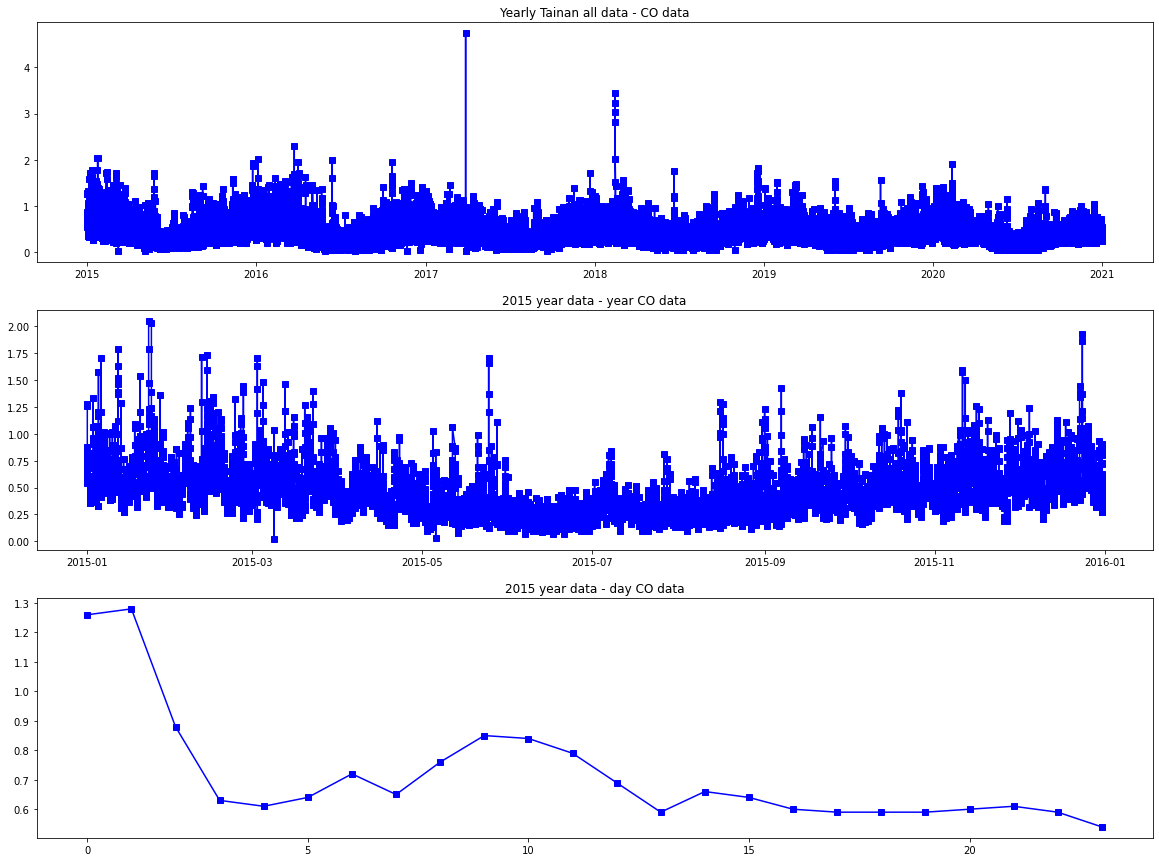

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - CO data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["CO"],'s-',color = 'b')

axs[1].title.set_text('2015 year data - year CO data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["CO"][:365*24],'s-',color = 'b')

axs[2].title.set_text('2015 year data - day CO data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["CO"][:24],'s-',color = 'b')

## NMHC 數據檢視與處理

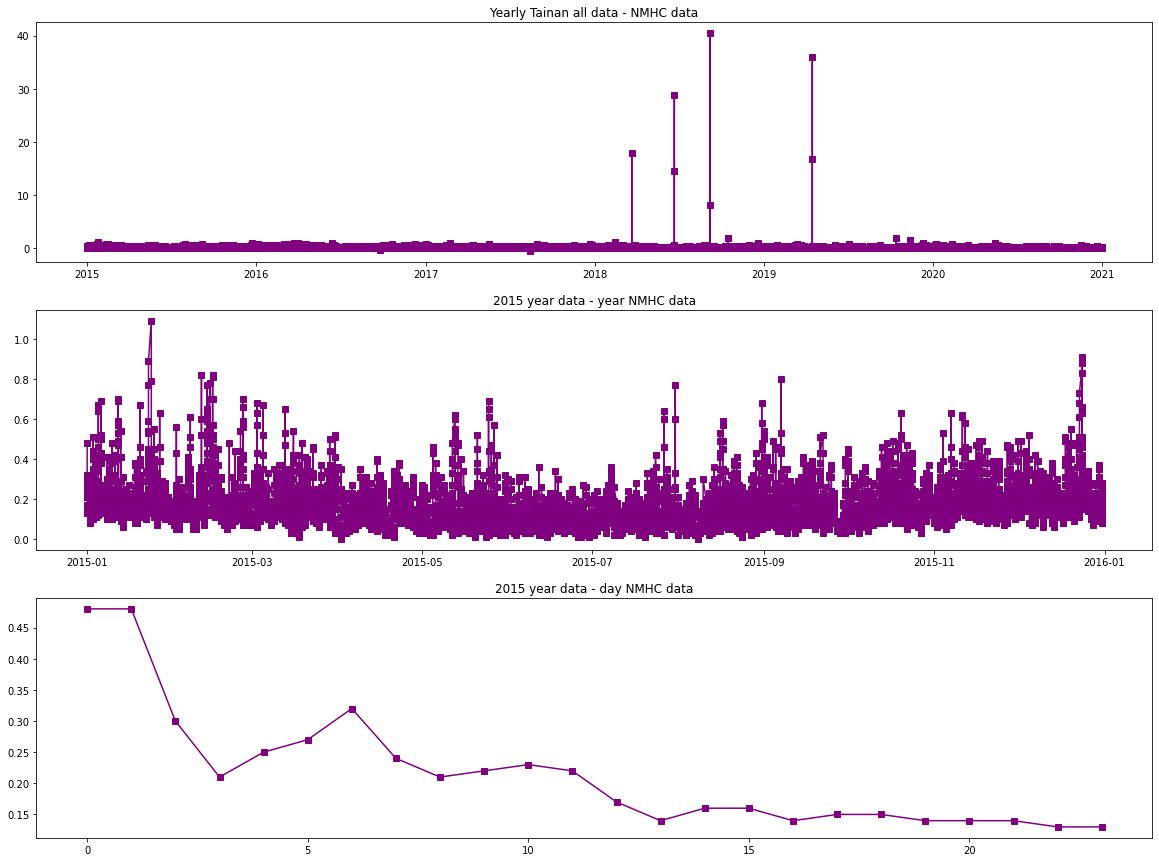

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NMHC data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NMHC"],'s-',color = 'purple')

axs[1].title.set_text('2015 year data - year NMHC data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NMHC"][:365*24],'s-',color = 'purple')

axs[2].title.set_text('2015 year data - day NMHC data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NMHC"][:24],'s-',color = 'purple')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NMHC"] > 10]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
28236,2018/03/22,臺南,12,23.299999,1.885,0.31,17.969999,1.4,5.5,6.9,64.000000,36.0,19.0,0.0,45.0,1.7,19.900000,262.0,247.0,2.0,1.8
30444,2018/06/22,臺南,12,29.500000,1.450,0.18,28.870001,2.7,3.9,6.6,27.700001,31.0,5.0,0.0,81.0,1.9,30.500000,216.0,215.0,3.8,2.9
30445,2018/06/22,臺南,13,27.900000,1.200,0.16,14.460000,3.1,4.7,7.7,21.299999,25.0,6.0,0.8,89.0,1.3,15.600000,183.0,160.0,1.8,1.8
32294,2018/09/07,臺南,14,31.500000,1.750,0.20,40.450001,3.1,3.6,6.7,33.400002,37.0,25.0,0.0,74.0,1.4,40.500000,251.0,253.0,3.0,3.0
37595,2019/04/16,臺南,11,23.500000,1.955,0.55,35.939999,4.5,21.5,26.0,398.799988,55.0,33.0,0.0,86.0,2.4,35.939999,337.0,2.0,0.5,1.6
37596,2019/04/16,臺南,12,24.700001,1.955,0.51,16.730000,3.1,17.4,20.5,0.000000,1000.0,33.0,0.0,82.0,2.5,16.730000,344.0,347.0,1.9,1.6


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NMHC"] < 0.0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
9033,2016/01/12,臺南,9,19.0,1.9,0.50,-0.02,6.0,15.0,21.0,23.0,30.0,15.0,0.0,78.0,2.4,1.9,51.0,57.0,1.9,2.2
12332,2016/05/28,臺南,20,29.0,1.7,0.11,-0.01,0.9,4.9,5.7,23.0,28.0,19.0,0.0,76.0,2.5,1.7,220.0,221.0,2.2,2.1
12333,2016/05/28,臺南,21,29.0,1.7,0.12,-0.01,0.9,5.6,6.5,20.0,20.0,12.0,0.0,78.0,2.7,1.7,207.0,184.0,1.6,1.8
12334,2016/05/28,臺南,22,29.0,1.7,0.10,-0.01,0.8,6.1,6.9,18.0,24.0,15.0,0.0,79.0,2.7,1.7,198.0,199.0,1.5,1.3
12335,2016/05/28,臺南,23,29.0,1.7,0.07,-0.01,0.9,5.7,6.6,18.0,27.0,6.0,0.0,80.0,2.4,1.7,192.0,187.0,1.5,1.4
12336,2016/05/29,臺南,0,29.0,1.7,0.12,-0.02,0.8,4.5,5.3,18.0,28.0,12.0,0.0,81.0,2.3,1.7,184.0,177.0,1.3,1.2
12337,2016/05/29,臺南,1,29.0,1.7,0.13,-0.01,0.9,6.0,6.9,16.0,33.0,6.0,0.0,81.0,2.4,1.7,162.0,149.0,1.7,1.4
15213,2016/09/25,臺南,21,27.0,4.1,0.24,-0.24,-0.1,8.2,8.2,19.0,46.0,26.0,0.0,78.0,2.6,3.8,12.0,35.0,1.4,0.8
15214,2016/09/25,臺南,22,27.0,3.5,0.33,-0.11,-0.3,11.0,11.0,15.0,53.0,21.0,0.0,79.0,3.1,3.4,71.0,99.0,0.8,0.9
22988,2017/08/15,臺南,20,31.0,3.0,0.14,-0.57,0.4,5.1,5.5,0.0,14.5,10.5,0.0,35.0,1.6,2.4,304.0,304.0,1.6,1.6


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["NMHC"] > 10, "NMHC"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["NMHC"] < 0.0, "NMHC"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["NMHC"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

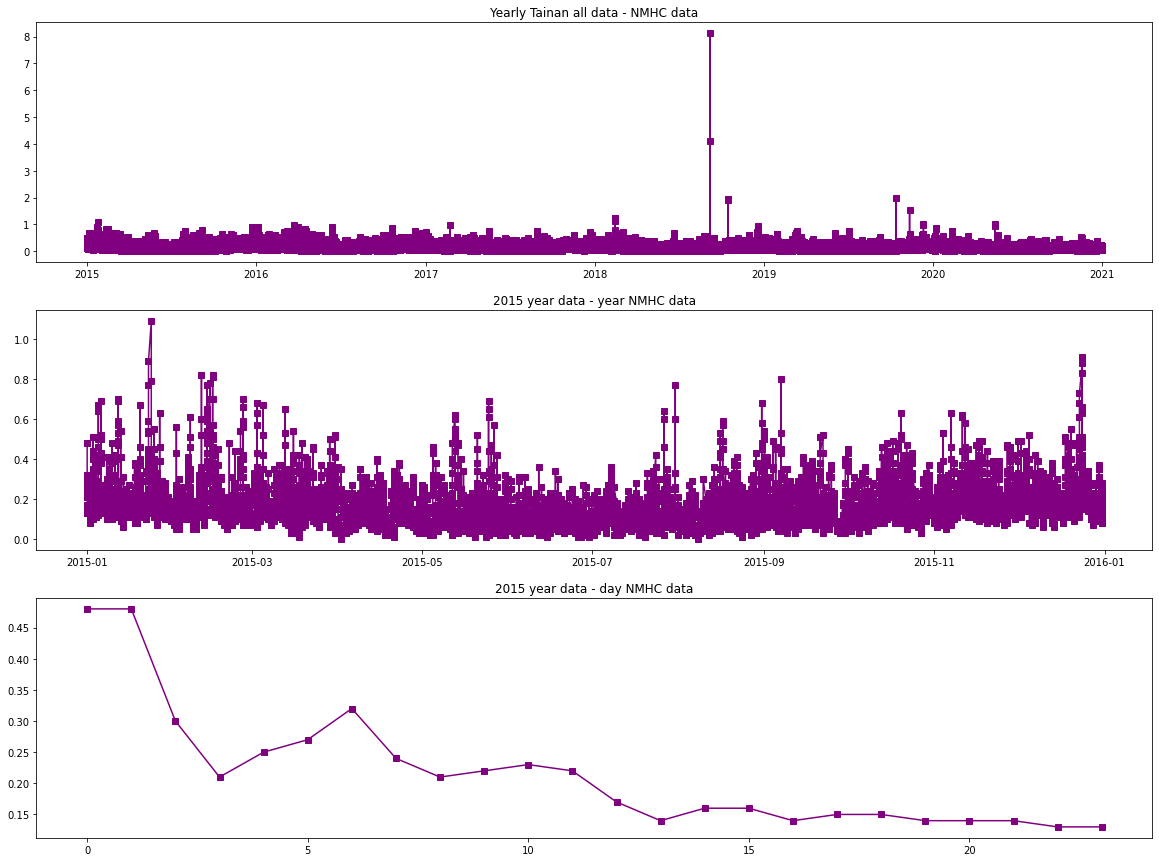

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NMHC data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NMHC"],'s-',color = 'purple')

axs[1].title.set_text('2015 year data - year NMHC data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NMHC"][:365*24],'s-',color = 'purple')

axs[2].title.set_text('2015 year data - day NMHC data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NMHC"][:24],'s-',color = 'purple')

## NO 數據檢視與處理

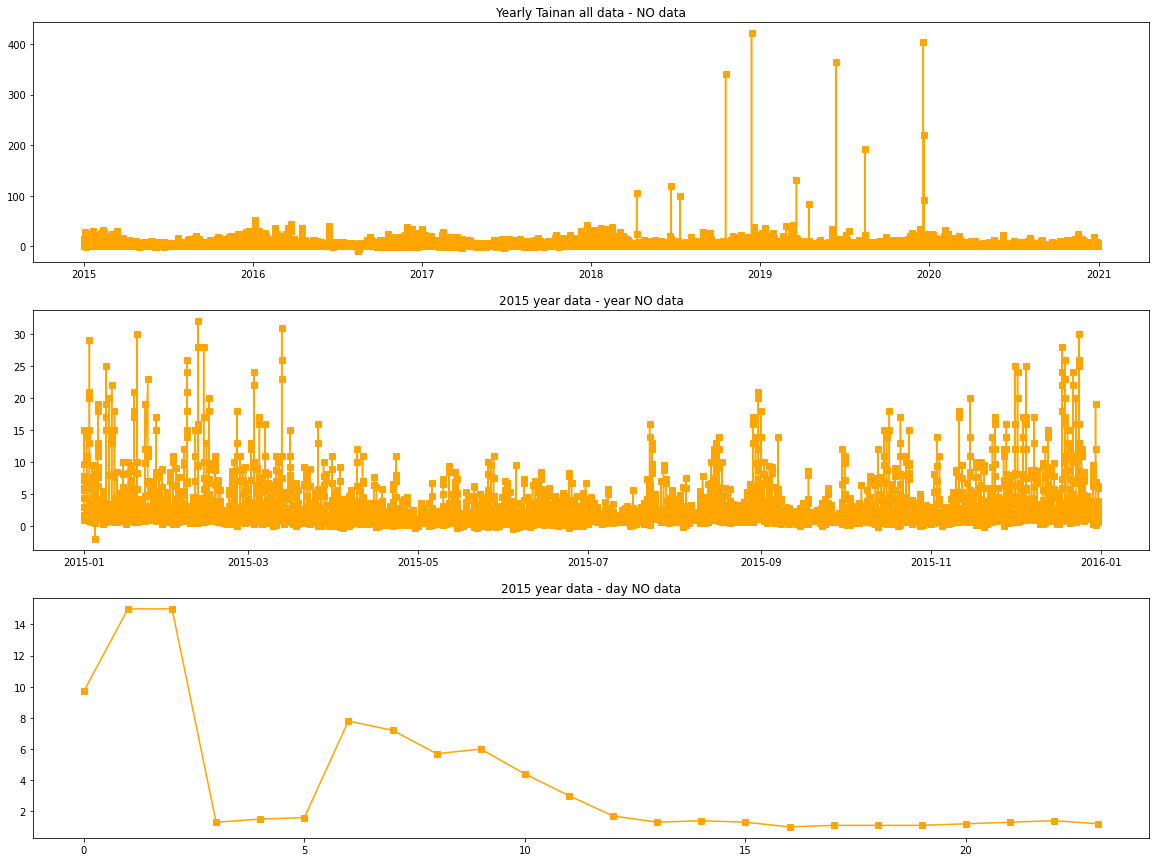

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NO data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NO"],'s-',color = 'orange')

axs[1].title.set_text('2015 year data - year NO data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NO"][:365*24],'s-',color = 'orange')

axs[2].title.set_text('2015 year data - day NO data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NO"][:24],'s-',color = 'orange')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NO"] > 80]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
28671,2018/04/09,臺南,15,25.400000,1.83,0.29,0.05,106.400002,262.399994,264.500000,71.000000,50.0,12.0,0.0,50.0,2.100000,1.88,292.0,294.0,3.5,3.0
30446,2018/06/22,臺南,14,28.900000,1.89,0.15,0.00,120.300003,459.399994,462.399994,23.000000,23.0,8.0,0.0,83.0,3.600000,1.89,179.0,175.0,2.5,2.2
30904,2018/07/11,臺南,16,31.400000,1.70,0.15,0.03,100.199997,1.700000,101.800003,28.100000,36.0,19.0,0.0,71.0,94.800003,1.70,221.0,225.0,4.3,3.8
33276,2018/10/18,臺南,12,28.700001,1.90,0.42,0.16,340.799988,288.399994,287.000000,73.099998,66.0,41.0,0.0,67.0,3.000000,2.10,281.0,291.0,2.0,2.0
34622,2018/12/13,臺南,14,24.900000,1.90,0.47,0.13,421.399994,425.899994,428.200012,57.299999,77.0,25.0,0.0,63.0,3.800000,2.10,316.0,342.0,2.4,2.3
36950,2019/03/20,臺南,14,28.900000,1.81,0.27,0.05,132.100006,448.299988,450.000000,56.799999,45.0,12.0,0.0,67.0,3.300000,1.86,209.0,209.0,3.3,0.3
37598,2019/04/16,臺南,14,24.700001,1.90,0.43,0.14,83.099998,463.500000,465.799988,46.799999,40.0,48.0,0.0,81.0,2.000000,2.04,12.0,5.0,2.6,2.6
38990,2019/06/13,臺南,14,29.500000,1.69,0.13,0.06,365.500000,363.600006,366.100006,22.700001,1000.0,772.0,7.0,83.0,1.500000,1.75,198.0,200.0,1.7,2.3
40503,2019/08/15,臺南,15,30.500000,1.70,0.20,0.04,192.699997,5.600000,198.300003,25.200001,25.0,7.0,0.0,83.0,2.100000,1.73,214.0,214.0,3.6,2.8
43527,2019/12/19,臺南,15,23.700001,1.87,0.39,0.10,403.899994,414.100006,412.899994,48.400002,44.0,24.0,0.0,76.0,2.200000,1.97,5.0,13.0,2.8,2.2


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NO"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
111,2015/01/05,臺南,15,25.0,1.8,0.83,0.160,-2.0,14.0,12.0,80.0,67.0,40.0,0.0,46.0,3.6,2.0,294.0,291.0,2.1,2.1
2226,2015/04/03,臺南,18,27.0,1.7,0.34,0.060,-0.1,8.6,8.5,29.0,29.0,7.0,0.0,80.0,1.4,1.8,220.0,225.0,3.0,2.2
2232,2015/04/04,臺南,0,26.0,1.8,0.42,0.200,-0.2,19.0,19.0,8.6,38.0,4.0,0.0,83.0,3.8,2.0,172.0,161.0,1.2,0.9
2540,2015/04/16,臺南,20,25.0,1.8,0.41,0.130,-0.1,12.0,11.0,48.0,39.0,20.0,0.0,77.0,1.6,1.9,12.0,38.0,1.7,0.9
2542,2015/04/16,臺南,22,25.0,1.8,0.37,0.130,-0.1,12.0,12.0,41.0,54.0,17.0,0.0,81.0,1.6,1.9,29.0,354.0,0.9,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23401,2017/09/02,臺南,1,29.0,1.8,0.26,0.130,-0.3,9.5,9.3,32.0,52.0,25.0,0.0,79.0,4.3,1.9,271.0,320.0,0.9,1.0
23402,2017/09/02,臺南,2,29.0,2.0,0.34,0.290,-0.3,13.0,13.0,25.0,50.0,24.0,0.0,81.0,3.7,2.3,31.0,30.0,1.7,1.3
23425,2017/09/03,臺南,1,28.0,1.9,0.20,0.080,-0.1,8.1,8.0,18.0,24.0,8.0,0.0,80.0,2.9,2.0,147.0,155.0,2.0,1.8
23844,2017/09/20,臺南,12,34.0,1.8,0.03,0.000,-0.9,-0.4,-1.3,0.0,62.0,27.0,0.0,45.0,-0.1,-0.1,335.0,349.0,3.6,2.6


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["NO"] > 80, "NO"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["NO"] < 0.0, "NO"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["NO"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

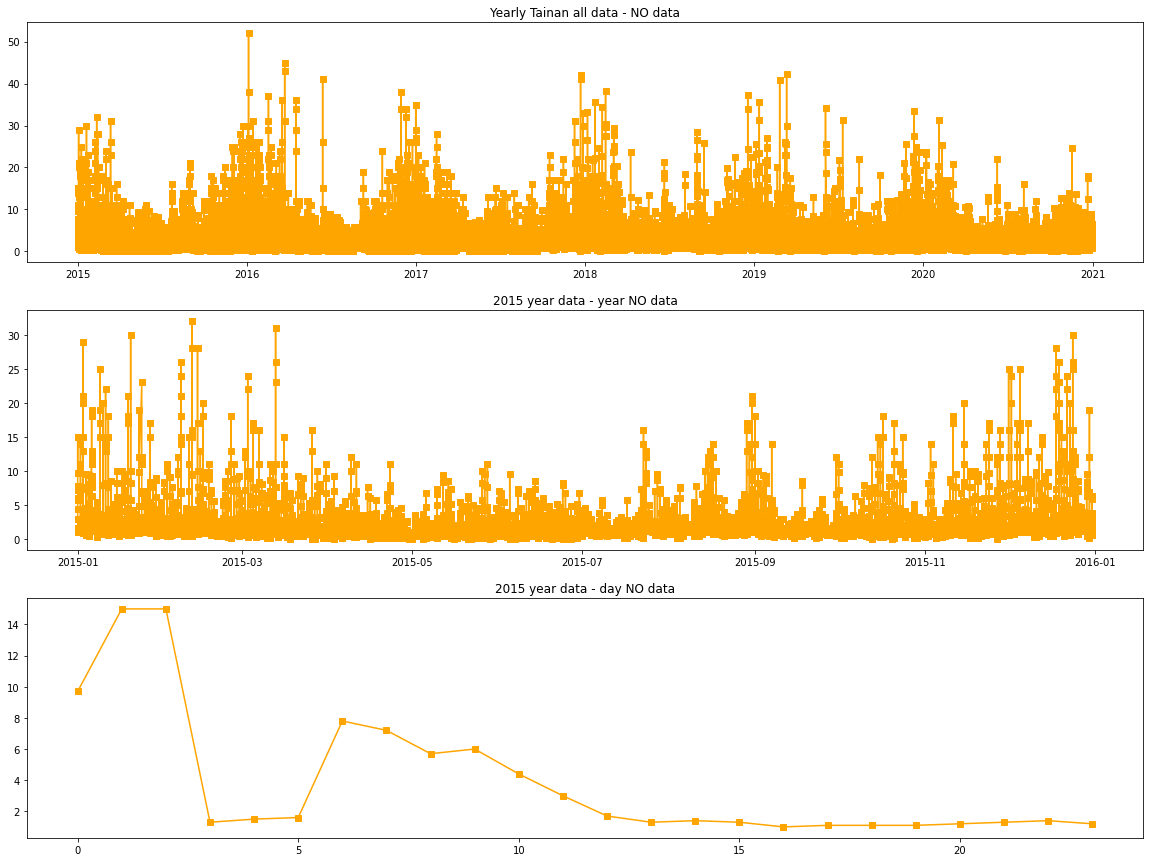

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NO data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NO"],'s-',color = 'orange')

axs[1].title.set_text('2015 year data - year NO data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NO"][:365*24],'s-',color = 'orange')

axs[2].title.set_text('2015 year data - day NO data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NO"][:24],'s-',color = 'orange')

## NO2 數據檢視與處理

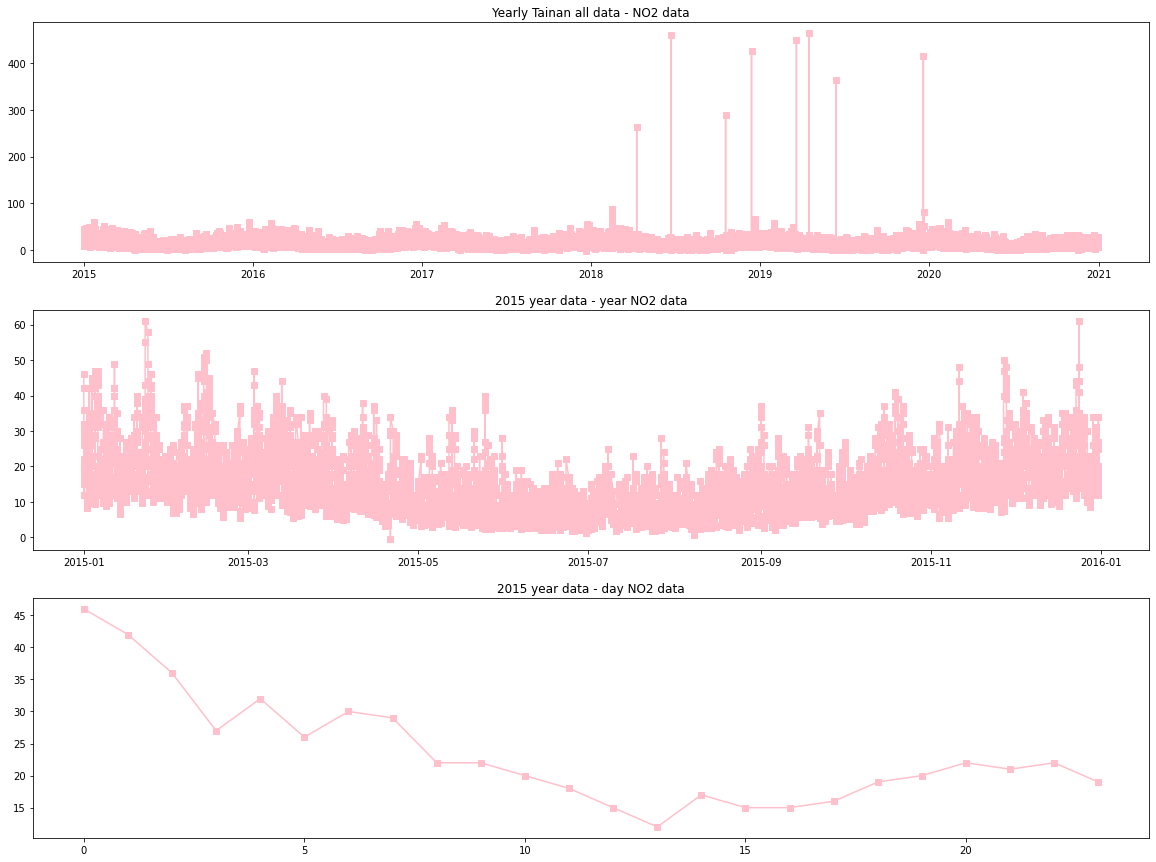

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NO2 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NO2"],'s-',color = 'pink')

axs[1].title.set_text('2015 year data - year NO2 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NO2"][:365*24],'s-',color = 'pink')

axs[2].title.set_text('2015 year data - day NO2 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NO2"][:24],'s-',color = 'pink')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NO2"] > 100]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
28671,2018/04/09,臺南,15,25.400000,1.83,0.29,0.05,12.95,262.399994,264.500000,71.000000,50.0,12.0,0.0,50.0,2.1,1.88,292.0,294.0,3.5,3.0
30446,2018/06/22,臺南,14,28.900000,1.89,0.15,0.00,4.15,459.399994,462.399994,23.000000,23.0,8.0,0.0,83.0,3.6,1.89,179.0,175.0,2.5,2.2
33276,2018/10/18,臺南,12,28.700001,1.90,0.42,0.16,0.30,288.399994,287.000000,73.099998,66.0,41.0,0.0,67.0,3.0,2.10,281.0,291.0,2.0,2.0
34622,2018/12/13,臺南,14,24.900000,1.90,0.47,0.13,2.65,425.899994,428.200012,57.299999,77.0,25.0,0.0,63.0,3.8,2.10,316.0,342.0,2.4,2.3
36950,2019/03/20,臺南,14,28.900000,1.81,0.27,0.05,2.60,448.299988,450.000000,56.799999,45.0,12.0,0.0,67.0,3.3,1.86,209.0,209.0,3.3,0.3
37598,2019/04/16,臺南,14,24.700001,1.90,0.43,0.14,2.50,463.500000,465.799988,46.799999,40.0,48.0,0.0,81.0,2.0,2.04,12.0,5.0,2.6,2.6
38990,2019/06/13,臺南,14,29.500000,1.69,0.13,0.06,2.90,363.600006,366.100006,22.700001,1000.0,772.0,7.0,83.0,1.5,1.75,198.0,200.0,1.7,2.3
43527,2019/12/19,臺南,15,23.700001,1.87,0.39,0.10,0.60,414.100006,412.899994,48.400002,44.0,24.0,0.0,76.0,2.2,1.97,5.0,13.0,2.8,2.2


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NO2"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
2656,2015/04/21,臺南,16,28.0,1.9,0.35,0.26,1.000,-0.5,0.5,24.0,35.0,9.0,0.4,83.0,-0.7,2.2,182.0,188.0,1.7,1.1
23844,2017/09/20,臺南,12,34.0,1.8,0.03,0.00,0.275,-0.4,-1.3,0.0,62.0,27.0,0.0,45.0,-0.1,-0.1,335.0,349.0,3.6,2.6
26054,2017/12/21,臺南,14,22.0,1.8,0.31,0.08,0.000,-2.4,0.0,56.0,70.0,22.0,0.0,55.0,2.0,1.9,249.0,226.0,1.1,1.3


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["NO2"] > 100, "NO2"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["NO2"] < 0.0, "NO2"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["NO2"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

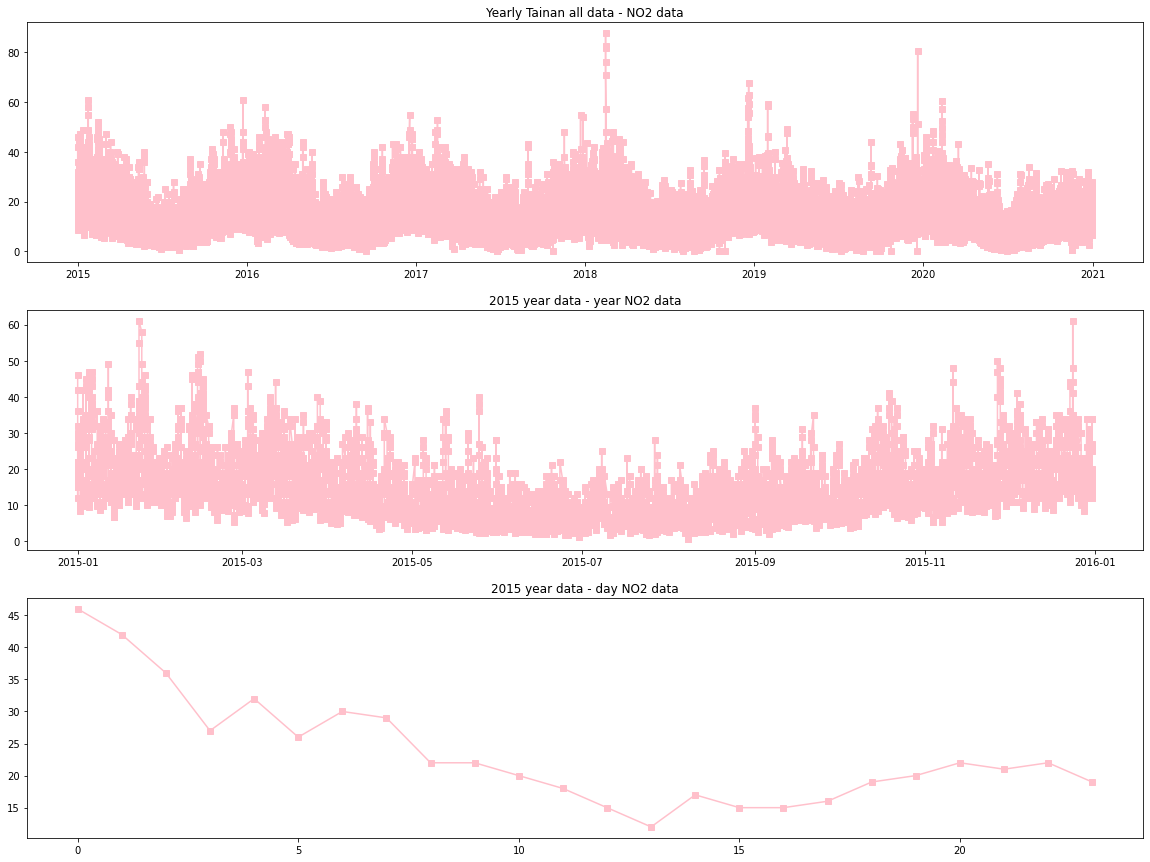

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NO2 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NO2"],'s-',color = 'pink')

axs[1].title.set_text('2015 year data - year NO2 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NO2"][:365*24],'s-',color = 'pink')

axs[2].title.set_text('2015 year data - day NO2 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NO2"][:24],'s-',color = 'pink')

## NOx 數據檢視與處理

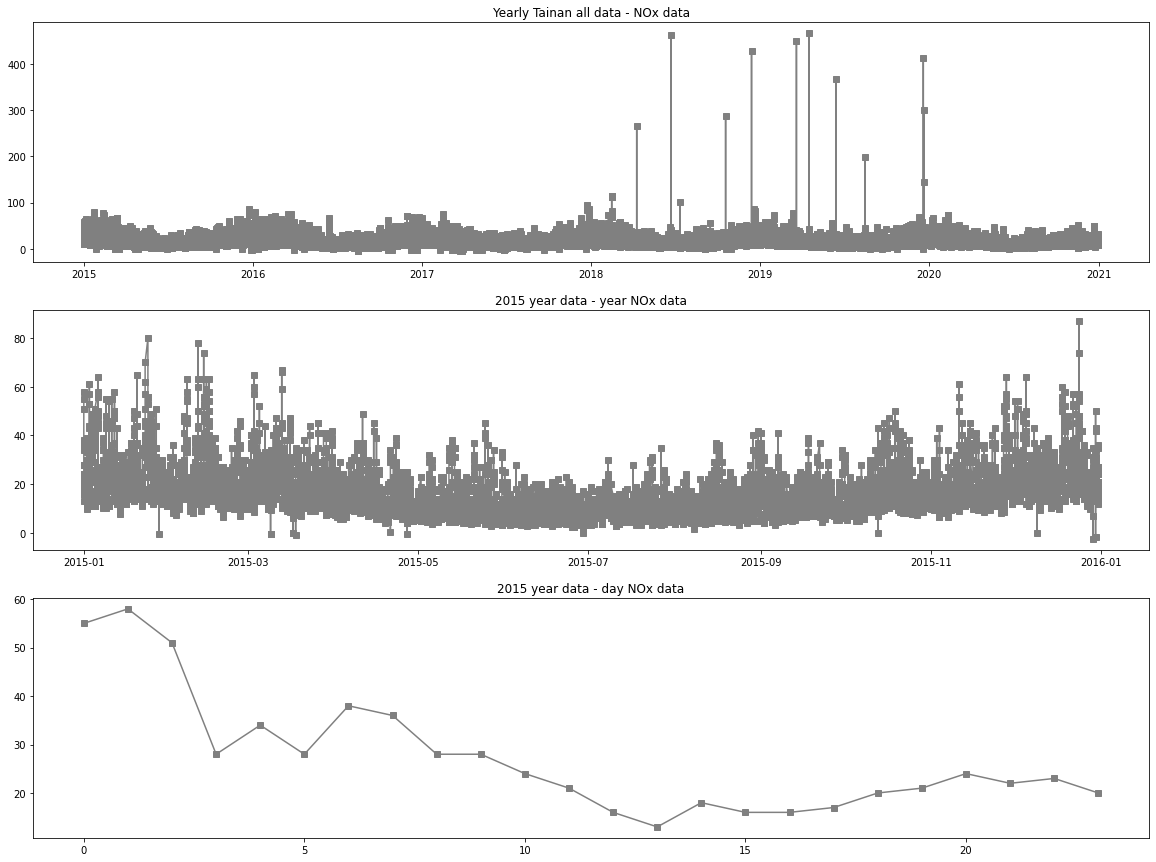

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NOx data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NOx"],'s-',color = 'gray')

axs[1].title.set_text('2015 year data - year NOx data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NOx"][:365*24],'s-',color = 'gray')

axs[2].title.set_text('2015 year data - day NOx data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NOx"][:24],'s-',color = 'gray')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NOx"] > 120]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
28671,2018/04/09,臺南,15,25.400000,1.83,0.29,0.05,12.95,4.950000,264.500000,71.000000,50.0,12.0,0.0,50.0,2.1,1.88,292.0,294.0,3.5,3.0
30446,2018/06/22,臺南,14,28.900000,1.89,0.15,0.00,4.15,6.300000,462.399994,23.000000,23.0,8.0,0.0,83.0,3.6,1.89,179.0,175.0,2.5,2.2
33276,2018/10/18,臺南,12,28.700001,1.90,0.42,0.16,0.30,3.250000,287.000000,73.099998,66.0,41.0,0.0,67.0,3.0,2.10,281.0,291.0,2.0,2.0
34622,2018/12/13,臺南,14,24.900000,1.90,0.47,0.13,2.65,10.750000,428.200012,57.299999,77.0,25.0,0.0,63.0,3.8,2.10,316.0,342.0,2.4,2.3
36950,2019/03/20,臺南,14,28.900000,1.81,0.27,0.05,2.60,9.350000,450.000000,56.799999,45.0,12.0,0.0,67.0,3.3,1.86,209.0,209.0,3.3,0.3
37598,2019/04/16,臺南,14,24.700001,1.90,0.43,0.14,2.50,19.299999,465.799988,46.799999,40.0,48.0,0.0,81.0,2.0,2.04,12.0,5.0,2.6,2.6
38990,2019/06/13,臺南,14,29.500000,1.69,0.13,0.06,2.90,3.250000,366.100006,22.700001,1000.0,772.0,7.0,83.0,1.5,1.75,198.0,200.0,1.7,2.3
40503,2019/08/15,臺南,15,30.500000,1.70,0.20,0.04,1.65,5.600000,198.300003,25.200001,25.0,7.0,0.0,83.0,2.1,1.73,214.0,214.0,3.6,2.8
43527,2019/12/19,臺南,15,23.700001,1.87,0.39,0.10,0.60,13.400000,412.899994,48.400002,44.0,24.0,0.0,76.0,2.2,1.97,5.0,13.0,2.8,2.2
43550,2019/12/20,臺南,14,20.500000,1.92,0.42,0.23,6.80,51.200001,143.899994,21.299999,36.0,18.0,0.0,88.0,2.1,2.16,18.0,33.0,1.6,1.4


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["NOx"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
664,2015/01/28,臺南,16,21.0,1.80,0.6000,0.210,1.000,16.500,-0.5,46.0,129.0,39.0,0.0,63.0,2.50,2.0,335.0,356.0,2.7,1.0
1621,2015/03/09,臺南,13,26.0,1.70,0.0200,0.090,0.500,10.450,-0.3,52.0,62.0,29.0,0.0,55.0,-0.30,1.8,359.0,0.0,0.0,0.7
1622,2015/03/09,臺南,14,27.0,1.80,0.5200,0.110,0.500,10.450,-0.3,54.0,74.5,29.0,0.0,51.0,2.30,1.9,360.0,354.0,3.6,1.0
1811,2015/03/17,臺南,11,28.0,1.70,0.2300,0.050,0.300,9.700,-0.2,38.0,36.0,13.0,0.0,64.0,2.80,1.8,222.0,221.0,4.9,4.3
1812,2015/03/17,臺南,12,28.0,1.70,0.2250,0.040,0.300,9.700,-0.2,37.0,40.0,13.0,0.0,64.0,2.10,1.7,224.0,229.0,4.9,4.2
1813,2015/03/17,臺南,13,28.0,1.70,0.2200,0.030,0.300,9.700,-0.2,37.0,33.0,16.0,0.0,66.0,2.10,1.7,223.0,225.0,5.1,4.8
1814,2015/03/17,臺南,14,28.0,1.70,0.2200,0.040,0.300,9.700,-0.2,34.0,26.0,19.0,0.0,67.0,1.80,1.7,221.0,230.0,4.3,4.0
1838,2015/03/18,臺南,14,28.0,1.70,0.2400,0.020,0.000,13.300,-0.8,39.0,36.0,15.0,0.0,55.0,1.80,1.7,207.0,196.0,4.2,3.9
2798,2015/04/27,臺南,14,30.0,1.80,0.2625,0.080,0.200,6.750,-0.5,0.0,56.5,26.0,0.0,51.0,0.50,1.9,278.0,280.0,2.9,2.9
8220,2015/12/09,臺南,12,25.0,2.00,0.5900,0.230,1.100,21.500,-0.2,57.0,73.0,34.0,0.0,69.0,4.40,2.3,294.0,302.0,2.1,1.8


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["NOx"] > 120, "NOx"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["NOx"] < 0.0, "NOx"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["NOx"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

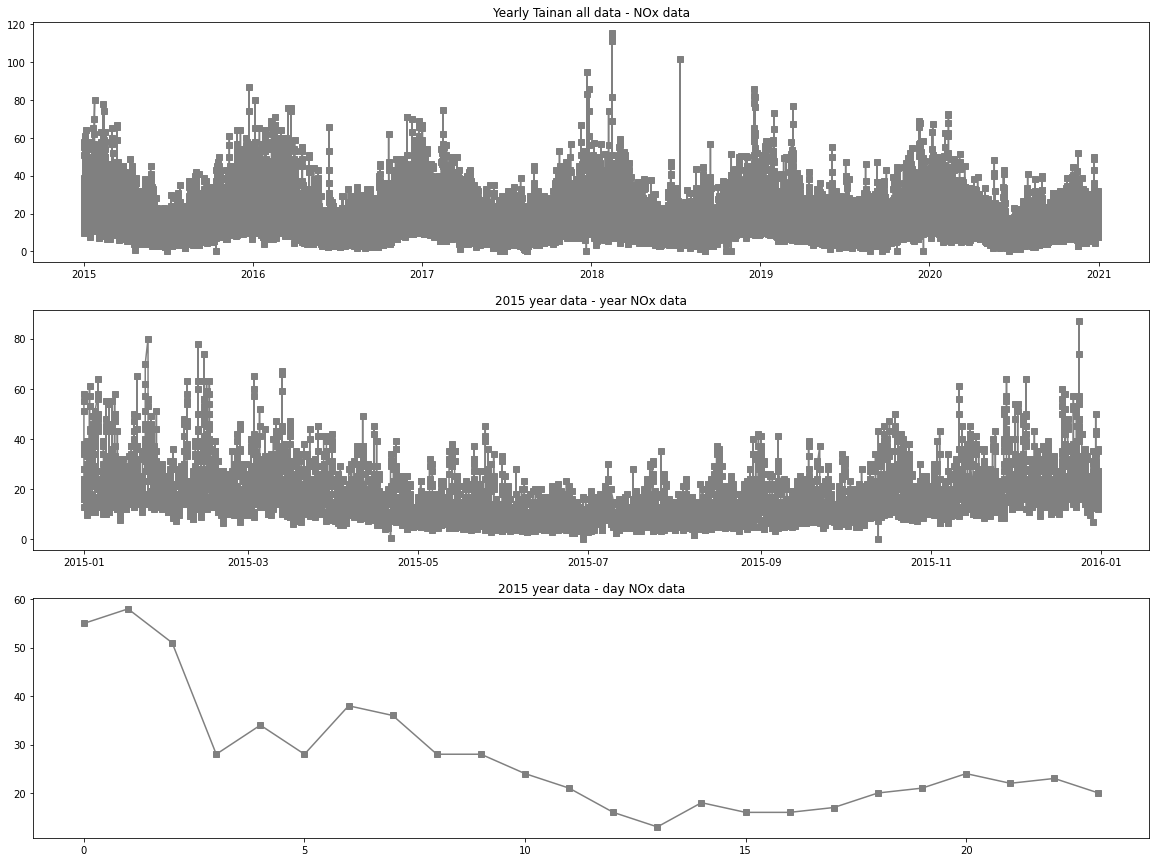

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - NOx data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["NOx"],'s-',color = 'gray')

axs[1].title.set_text('2015 year data - year NOx data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["NOx"][:365*24],'s-',color = 'gray')

axs[2].title.set_text('2015 year data - day NOx data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["NOx"][:24],'s-',color = 'gray')

## O3 數據檢視與處理

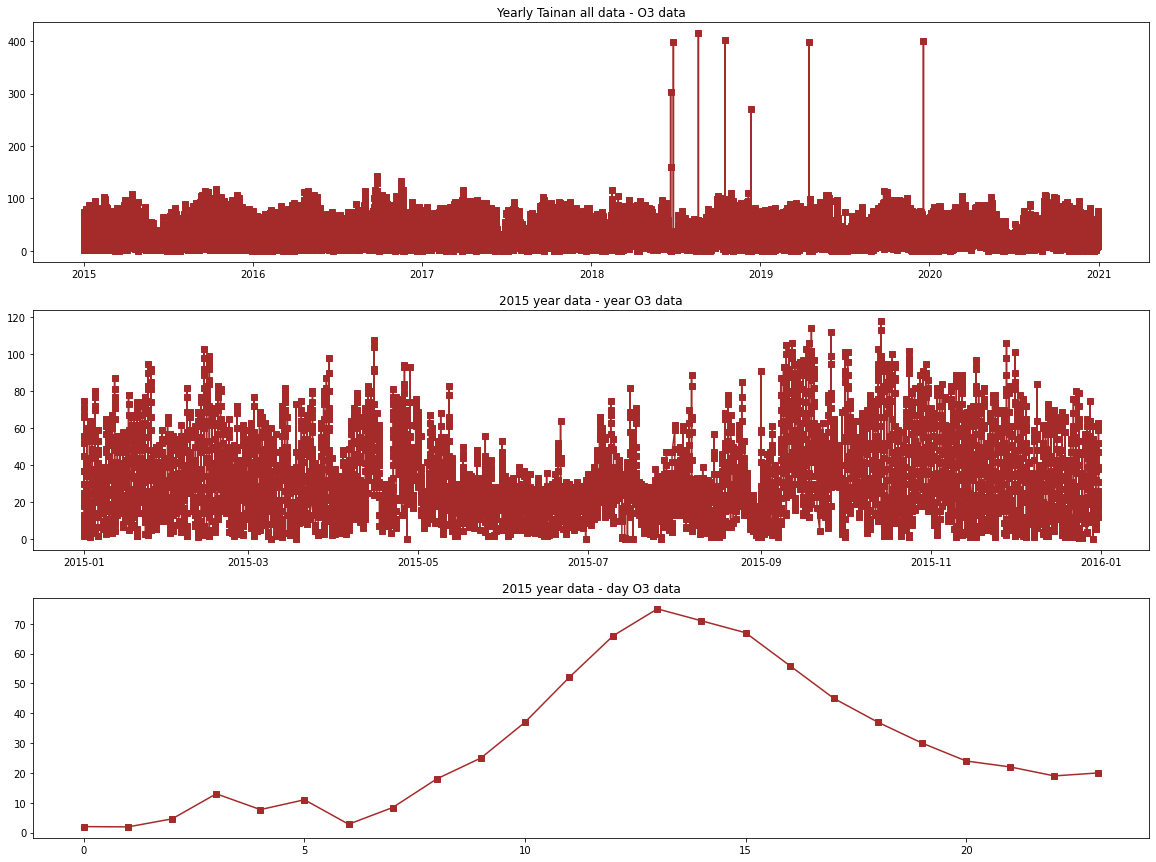

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - O3 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["O3"],'s-',color = 'brown')

axs[1].title.set_text('2015 year data - year O3 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["O3"][:365*24],'s-',color = 'brown')

axs[2].title.set_text('2015 year data - day O3 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["O3"][:24],'s-',color = 'brown')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["O3"] > 170]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
30421,2018/06/21,臺南,13,25.799999,1.800,0.34,0.20,10.7,23.9,34.599998,303.399994,25.0,11.0,3.2,95.0,2.2,2.000000,146.0,148.0,1.7,1.8
30564,2018/06/27,臺南,12,31.500000,1.600,0.18,0.05,2.4,3.8,6.200000,397.700012,33.0,11.0,0.0,70.0,2.2,1.600000,277.0,272.0,3.4,3.0
31859,2018/08/20,臺南,11,31.400000,1.750,0.17,0.04,2.0,2.8,4.800000,415.200012,36.0,1.0,0.0,70.0,3.1,1.790000,235.0,231.0,4.1,3.7
33251,2018/10/17,臺南,11,29.200001,1.900,0.41,0.13,2.2,8.8,11.100000,401.600006,75.0,33.0,0.0,66.0,2.7,2.100000,12.0,22.0,1.9,1.8
34597,2018/12/12,臺南,13,21.600000,1.900,0.39,0.14,3.7,17.9,21.600000,271.000000,63.0,14.0,0.0,66.0,2.7,2.000000,179.0,179.0,2.7,2.7
37595,2019/04/16,臺南,11,23.500000,1.955,0.55,0.24,4.5,21.5,26.000000,398.799988,55.0,33.0,0.0,86.0,2.4,35.939999,337.0,2.0,0.5,1.6
43526,2019/12/19,臺南,14,23.799999,1.870,0.40,0.09,0.0,15.0,11.100000,400.100006,58.0,1000.0,0.0,76.0,1.8,1.960000,359.0,356.0,2.5,2.4


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["O3"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
9749,2016/02/11,臺南,5,18.0,2.6,1.05,0.44,14.0,34.0,48.0,-0.8,78.0,42.0,0.0,75.0,1.7,3.1,38.0,31.0,1.4,0.7


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["O3"] > 170, "O3"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["O3"] < 0.0, "O3"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["O3"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

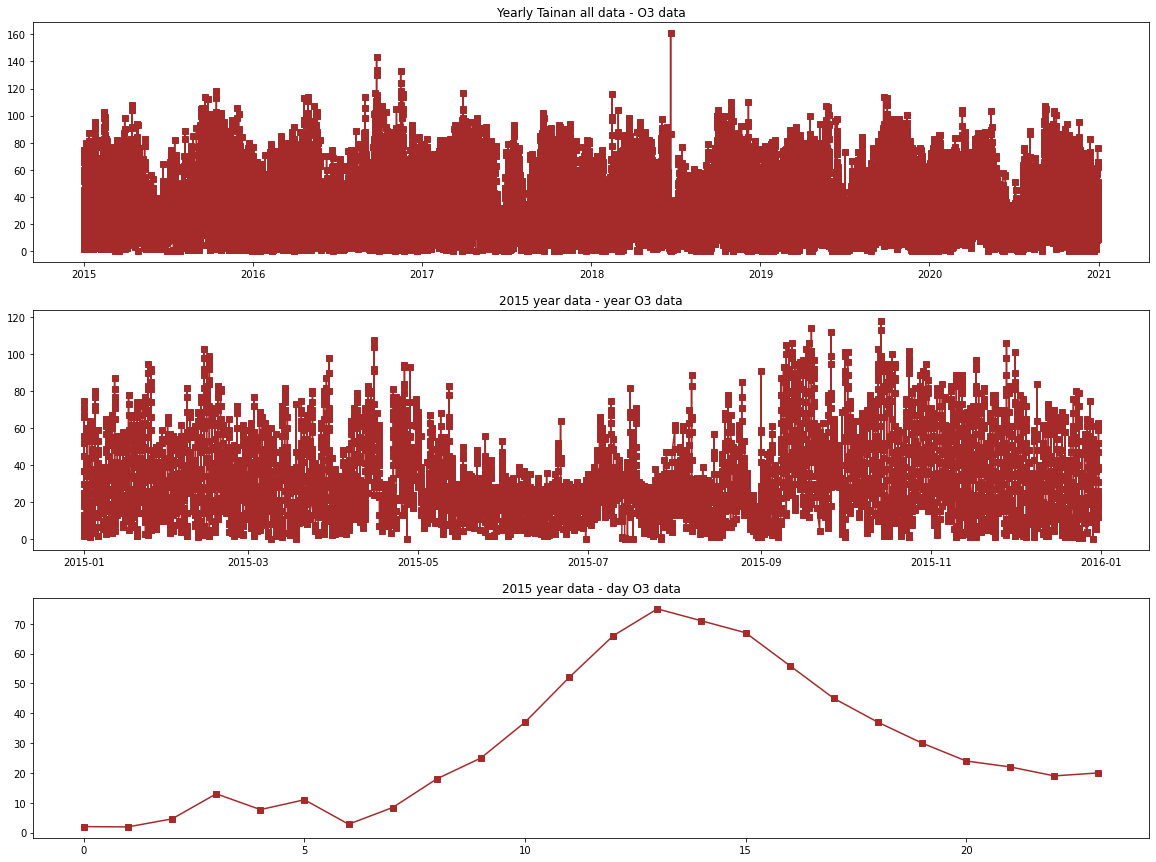

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - O3 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["O3"],'s-',color = 'brown')

axs[1].title.set_text('2015 year data - year O3 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["O3"][:365*24],'s-',color = 'brown')

axs[2].title.set_text('2015 year data - day O3 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["O3"][:24],'s-',color = 'brown')

## PM10 數據檢視與處理

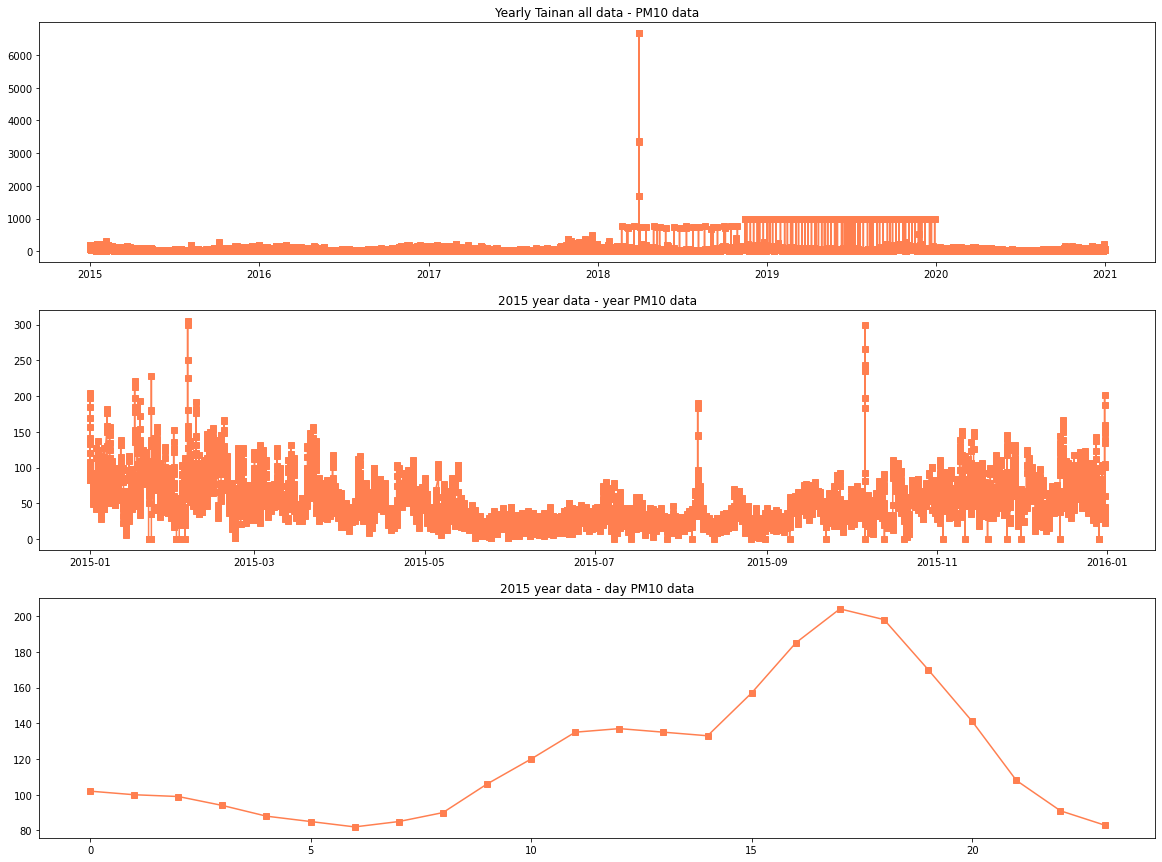

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - PM10 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["PM10"],'s-',color = 'Coral')

axs[1].title.set_text('2015 year data - year PM10 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["PM10"][:365*24],'s-',color = 'Coral')

axs[2].title.set_text('2015 year data - day PM10 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["PM10"][:24],'s-',color = 'Coral')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["PM10"] > 1000]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
28470,2018/04/01,臺南,6,23.000000,2.01,0.42,0.15,2.3,17.4,19.700001,22.000000,3359.0,34.0,0.0,81.0,6.1,2.16,153.0,143.0,1.2,0.9
28472,2018/04/01,臺南,8,24.900000,1.85,0.27,0.05,1.8,8.5,10.300000,51.000000,6666.0,33.0,0.0,69.0,3.1,1.90,245.0,265.0,1.7,0.8
28473,2018/04/01,臺南,9,26.200001,1.81,0.22,0.02,1.6,4.6,6.200000,56.000000,6666.0,27.0,0.0,59.0,2.0,1.83,276.0,292.0,2.8,1.9
28474,2018/04/01,臺南,10,27.100000,1.80,0.22,0.00,1.6,3.8,5.300000,53.099998,3333.0,30.0,0.0,55.0,1.6,1.80,269.0,257.0,3.1,2.3
28475,2018/04/01,臺南,11,27.400000,1.80,0.22,0.03,1.5,3.9,5.400000,51.400002,1702.5,19.0,0.0,52.0,1.5,1.80,273.0,268.0,2.7,2.3
28476,2018/04/01,臺南,12,27.900000,1.80,0.20,0.02,1.8,3.9,5.700000,51.000000,1702.5,22.0,0.0,52.0,1.5,1.82,251.0,234.0,3.0,2.4
28477,2018/04/01,臺南,13,28.400000,1.80,0.21,0.03,1.7,4.2,5.900000,52.000000,1702.5,17.0,0.0,50.0,1.8,1.82,257.0,246.0,2.9,2.3
28478,2018/04/01,臺南,14,28.299999,1.80,0.21,0.03,1.7,4.7,6.400000,51.000000,1702.5,25.0,0.0,51.0,1.7,1.83,271.0,299.0,3.5,2.9


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["PM10"] < 0.0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["PM10"] > 1000, "PM10"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["PM10"] < 0.0, "PM10"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["PM10"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

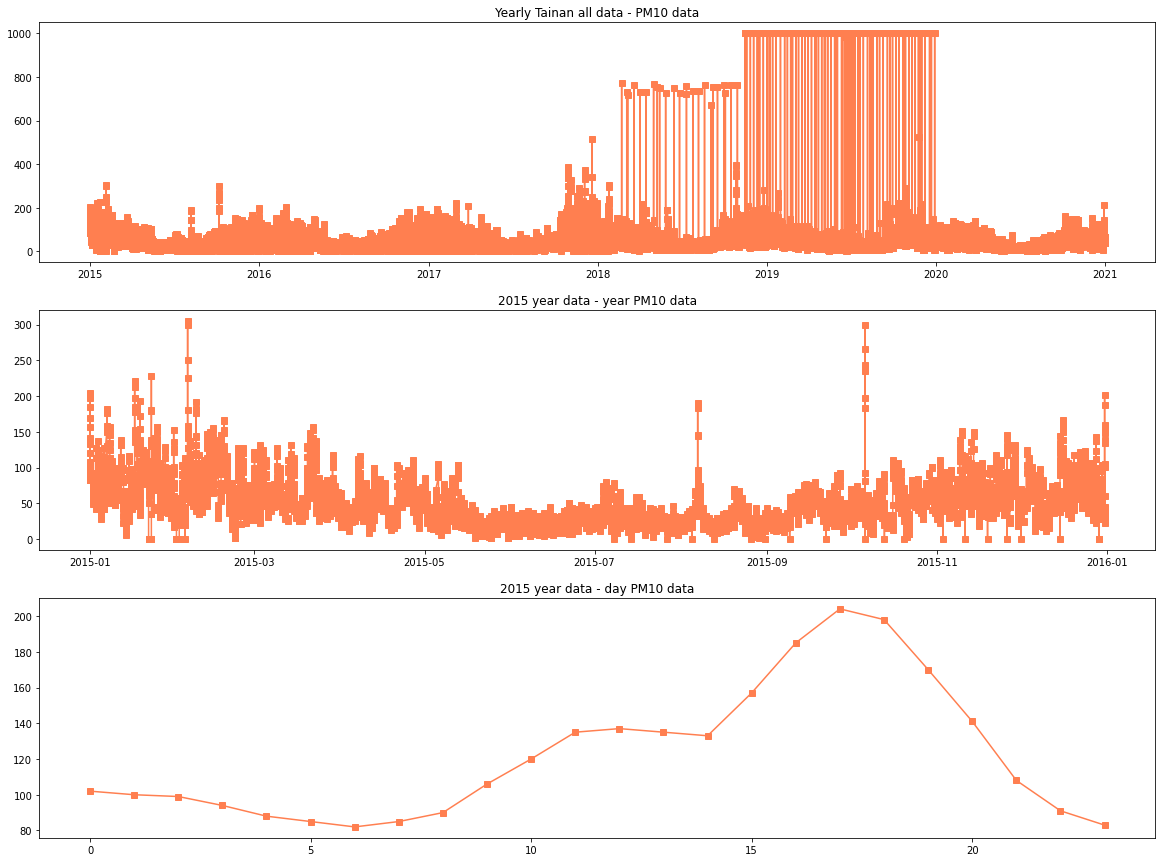

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - PM10 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["PM10"],'s-',color = 'Coral')

axs[1].title.set_text('2015 year data - year PM10 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["PM10"][:365*24],'s-',color = 'Coral')

axs[2].title.set_text('2015 year data - day PM10 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["PM10"][:24],'s-',color = 'Coral')

## PM2.5 數據檢視與處理

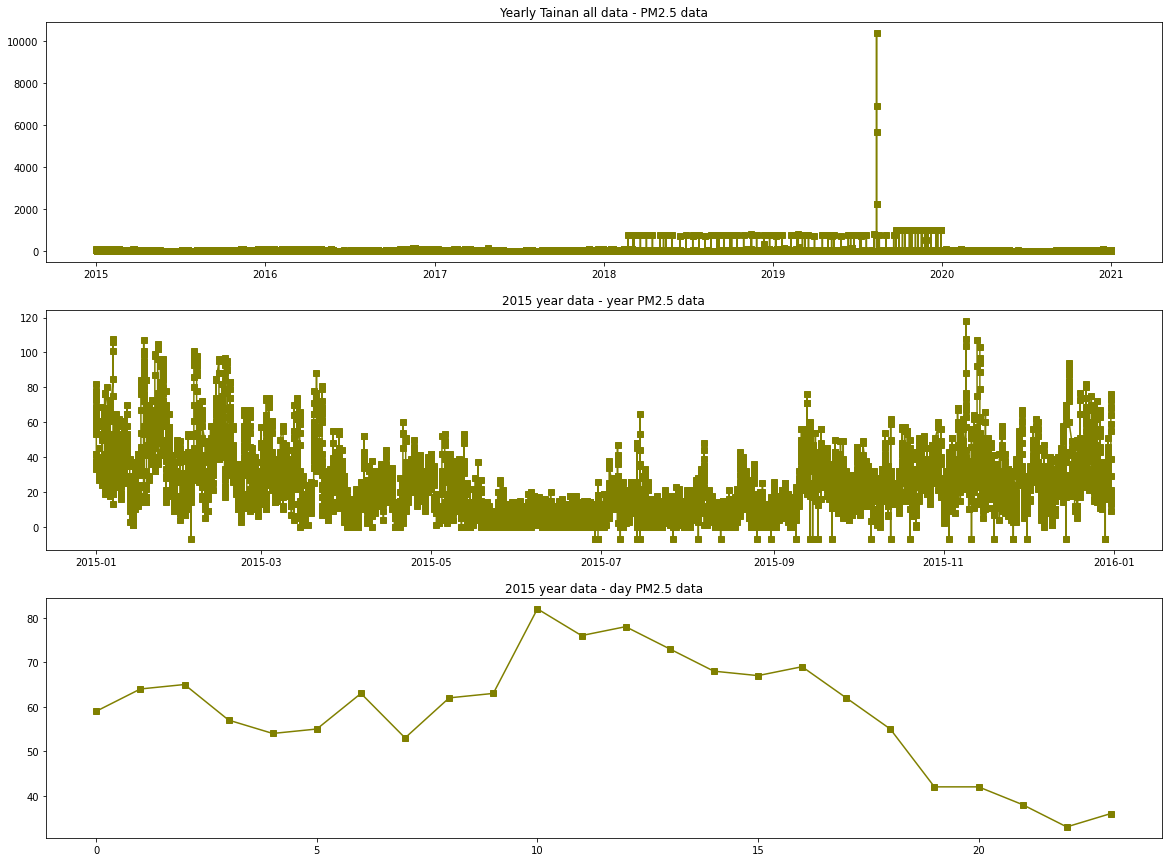

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - PM2.5 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["PM2.5"],'s-',color = 'Olive')

axs[1].title.set_text('2015 year data - year PM2.5 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["PM2.5"][:365*24],'s-',color = 'Olive')

axs[2].title.set_text('2015 year data - day PM2.5 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["PM2.5"][:24],'s-',color = 'Olive')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["PM2.5"] > 1500]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
40445,2019/08/13,臺南,5,25.400000,1.81,0.15,0.04,0.6,3.5,4.1,30.299999,5.0,2246.0,26.200001,98.0,0.5,1.85,132.0,146.0,2.3,1.9
40446,2019/08/13,臺南,6,25.100000,1.82,0.19,0.05,0.6,4.7,5.4,35.099998,5.0,2242.0,9.600000,98.0,1.0,1.86,139.0,110.0,1.9,2.1
40447,2019/08/13,臺南,7,25.200001,1.86,0.31,0.12,0.7,12.6,13.3,28.100000,5.0,5703.0,4.200000,98.0,1.2,1.98,119.0,123.0,2.4,2.0
40448,2019/08/13,臺南,8,25.600000,1.86,0.32,0.10,1.1,10.2,11.2,21.799999,5.0,6925.0,6.000000,98.0,1.1,1.96,108.0,106.0,2.3,2.0
40449,2019/08/13,臺南,9,25.799999,1.85,0.35,0.15,1.9,13.4,15.3,18.900000,10.0,10391.0,3.000000,97.0,1.2,2.00,77.0,74.0,2.3,1.8


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["PM2.5"] < 0.0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
828,2015/02/04,臺南,12,22.0,1.8,0.45,0.12,1.8,8.0,9.8,52.0,0.0,-7.0,0.0,59.0,1.6,1.9,17.0,335.0,3.6,1.1
4315,2015/06/29,臺南,19,30.0,1.8,0.46,0.09,0.7,6.6,7.4,17.0,20.0,-7.0,0.0,70.0,0.8,1.9,192.0,194.0,1.3,1.3
4316,2015/06/29,臺南,20,30.0,1.8,0.45,0.09,1.2,6.9,8.1,17.0,21.0,-7.0,0.0,69.0,1.0,1.9,192.0,197.0,1.4,1.1
4317,2015/06/29,臺南,21,30.0,1.9,0.45,0.08,1.2,6.6,7.8,16.0,26.0,-7.0,0.0,70.0,1.0,1.9,192.0,202.0,1.5,1.2
4318,2015/06/29,臺南,22,30.0,1.8,0.34,0.05,1.4,4.1,5.5,17.0,27.0,-7.0,0.0,71.0,0.9,1.9,202.0,208.0,1.8,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25499,2017/11/28,臺南,11,27.0,1.9,0.46,0.14,2.3,15.0,17.0,66.0,0.0,-7.0,0.0,71.0,3.5,2.1,322.0,322.0,1.9,1.5
25667,2017/12/05,臺南,11,22.0,1.9,0.44,0.16,3.3,13.0,16.0,46.0,0.0,-7.0,0.0,59.0,2.2,2.0,4.7,17.0,3.1,2.8
26030,2017/12/20,臺南,14,22.0,1.8,0.38,0.14,1.9,15.0,17.0,39.0,0.0,-7.0,0.0,57.0,3.0,2.0,4.2,7.6,3.9,2.8
26031,2017/12/20,臺南,15,21.0,1.8,0.32,0.12,0.9,13.0,14.0,40.0,0.0,-7.0,0.0,60.0,2.5,1.9,6.7,7.1,4.1,3.9


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["PM2.5"] > 1500, "PM2.5"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["PM2.5"] < 0.0, "PM2.5"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["PM2.5"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

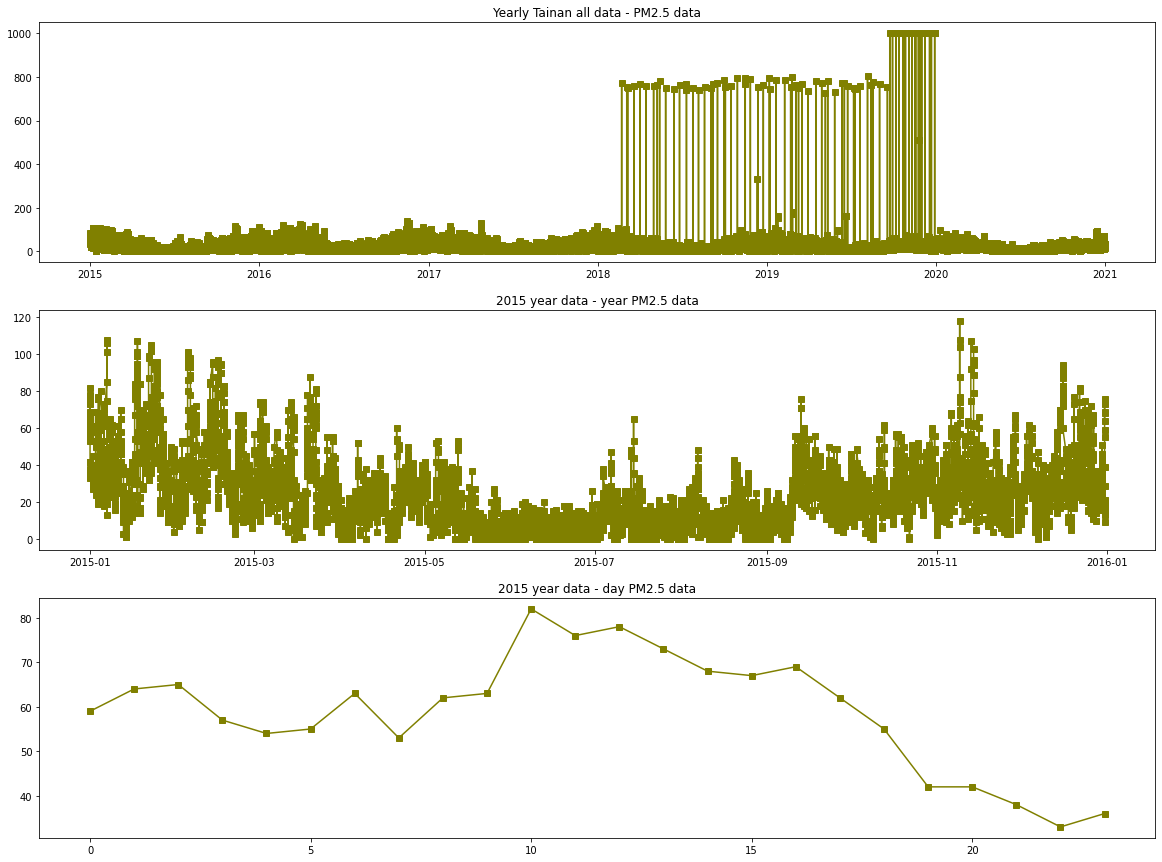

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - PM2.5 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["PM2.5"],'s-',color = 'Olive')

axs[1].title.set_text('2015 year data - year PM2.5 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["PM2.5"][:365*24],'s-',color = 'Olive')

axs[2].title.set_text('2015 year data - day PM2.5 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["PM2.5"][:24],'s-',color = 'Olive')

## RAINFALL 數據檢視與處理

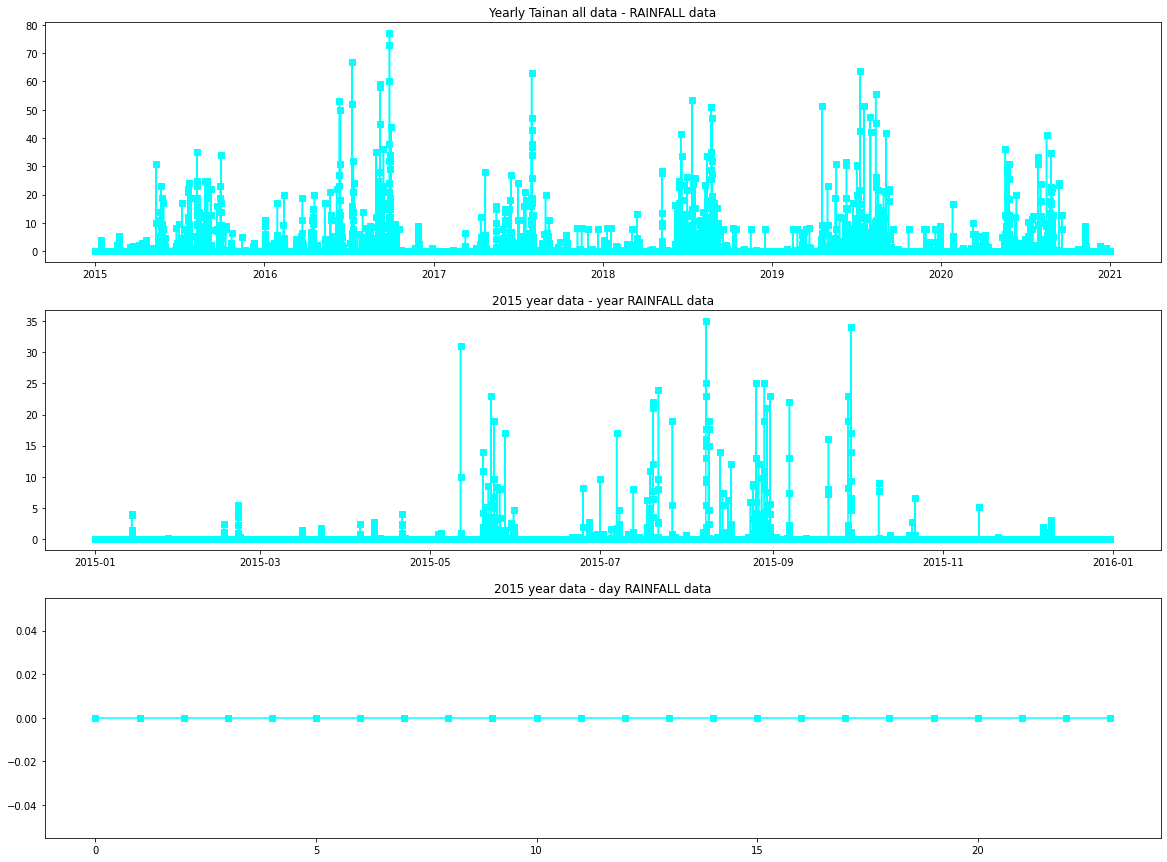

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - RAINFALL data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["RAINFALL"],'s-',color = 'Cyan')

axs[1].title.set_text('2015 year data - year RAINFALL data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["RAINFALL"][:365*24],'s-',color = 'Cyan')

axs[2].title.set_text('2015 year data - day RAINFALL data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["RAINFALL"][:24],'s-',color = 'Cyan')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["RAINFALL"] > 100]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["RAINFALL"] < 0.0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


無離群值

## RH 數據檢視與處理

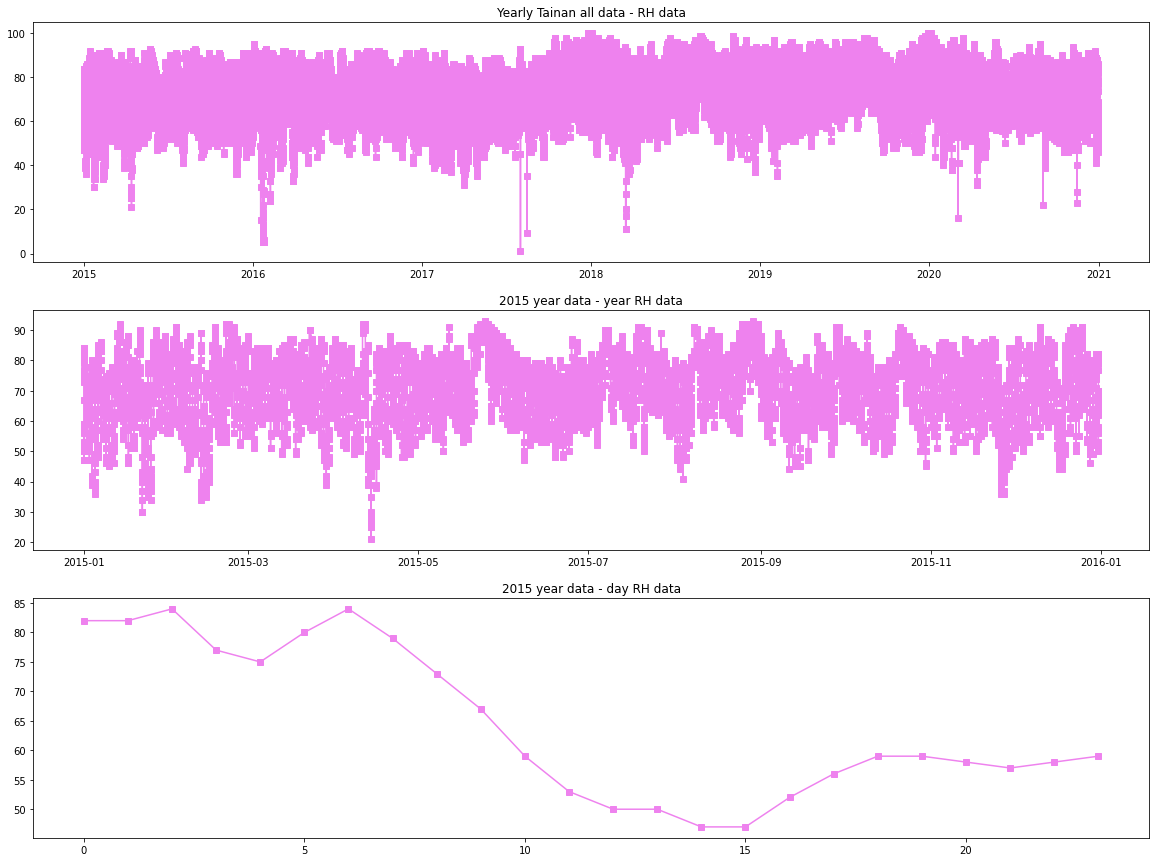

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - RH data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["RH"],'s-',color = 'Violet')

axs[1].title.set_text('2015 year data - year RH data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["RH"][:365*24],'s-',color = 'Violet')

axs[2].title.set_text('2015 year data - day RH data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["RH"][:24],'s-',color = 'Violet')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["RH"] > 120]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["RH"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


不須處理離群值

## SO2 數據檢視與處理

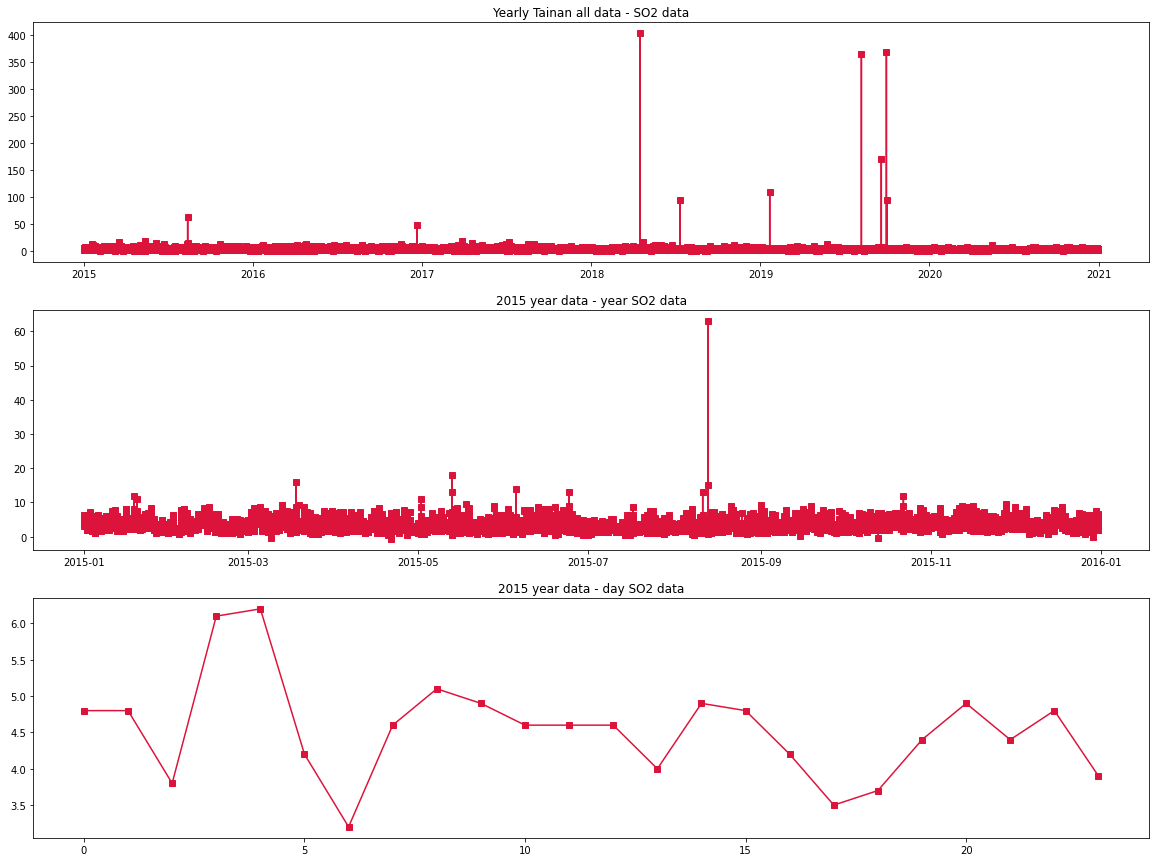

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - SO2 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["SO2"],'s-',color = '#DC143C')

axs[1].title.set_text('2015 year data - year SO2 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["SO2"][:365*24],'s-',color = '#DC143C')

axs[2].title.set_text('2015 year data - day SO2 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["SO2"][:24],'s-',color = '#DC143C')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["SO2"] > 40]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
5389,2015/08/13,臺南,13,30.000000,1.80,0.140,0.05,2.100,3.8,5.900000,26.000000,5.0,2.0,0.0,72.0,63.000000,1.80,249.0,278.0,2.9,2.8
17270,2016/12/20,臺南,14,26.000000,1.80,0.435,0.20,2.275,26.0,26.000000,48.000000,84.0,63.0,0.0,62.0,49.000000,2.00,294.0,295.0,2.1,1.5
28835,2018/04/16,臺南,11,28.000000,1.94,0.510,0.15,2.700,13.5,16.200001,74.000000,733.0,758.0,0.0,57.0,403.700012,2.09,284.0,303.0,2.4,1.4
30904,2018/07/11,臺南,16,31.400000,1.70,0.150,0.03,1.650,1.7,101.800003,28.100000,36.0,19.0,0.0,71.0,94.800003,1.70,221.0,225.0,4.3,3.8
35557,2019/01/21,臺南,13,18.000000,1.94,0.500,0.14,3.600,17.6,21.200001,30.900000,50.0,34.0,0.0,77.0,110.099998,2.08,14.0,24.0,3.0,2.7
40311,2019/08/07,臺南,15,32.099998,1.75,0.240,0.05,0.800,5.5,6.300000,45.400002,41.0,16.0,0.0,71.0,364.899994,1.80,315.0,311.0,2.9,2.3
41342,2019/09/19,臺南,14,32.000000,1.88,0.300,0.09,1.600,8.6,10.100000,12.200000,1000.0,753.0,0.0,56.0,170.300003,1.96,322.0,330.0,3.6,2.8
41606,2019/09/30,臺南,14,31.299999,1.83,0.270,0.08,0.300,0.0,1.000000,51.400002,1000.0,1000.0,0.0,69.0,368.799988,1.91,265.0,168.0,0.6,0.9
41627,2019/10/01,臺南,11,31.500000,1.75,0.250,0.08,2.700,5.3,8.000000,38.500000,31.0,13.0,0.0,61.0,95.400002,1.83,288.0,276.0,3.0,2.4


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["SO2"] < 0.0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
1621,2015/03/09,臺南,13,26.0,1.70,0.02,0.090,0.500,10.450,12.250,52.0,62.0,29.0,0.0,55.0,-0.3,1.8,359.0,0.0,0.0,0.7
2656,2015/04/21,臺南,16,28.0,1.90,0.35,0.260,1.000,14.625,0.500,24.0,35.0,9.0,0.4,83.0,-0.7,2.2,182.0,188.0,1.7,1.1
6853,2015/10/13,臺南,13,29.0,2.00,0.41,0.100,0.000,11.400,0.100,89.5,39.0,24.0,0.0,57.0,-0.4,2.1,291.0,303.0,1.9,1.6
10435,2016/03/10,臺南,19,12.0,1.90,0.43,0.150,1.600,20.000,22.000,22.0,15.0,2.0,3.6,89.0,-0.2,2.0,55.0,41.0,4.1,1.8
10438,2016/03/10,臺南,22,12.0,1.90,0.38,0.140,1.300,14.000,15.000,24.0,18.0,9.0,1.2,91.0,-0.2,2.0,53.0,56.0,3.4,2.6
11941,2016/05/12,臺南,13,31.0,1.90,0.37,0.120,1.600,10.000,12.000,75.0,72.0,37.0,0.0,56.0,-0.6,2.0,249.0,256.0,2.7,2.4
11942,2016/05/12,臺南,14,30.0,1.80,0.29,0.100,1.400,6.100,7.500,76.0,53.0,23.0,0.0,59.0,-0.6,1.9,256.0,261.0,2.9,2.8
12928,2016/06/22,臺南,16,32.0,1.70,0.09,0.070,1.800,2.200,4.000,18.0,23.0,7.0,0.0,64.0,-0.1,1.8,237.0,236.0,2.6,2.6
19620,2017/03/28,臺南,12,27.0,1.65,0.02,0.095,1.400,9.550,5.275,0.0,73.0,39.0,0.0,45.0,-0.1,0.0,317.0,273.0,2.9,0.8
19621,2017/03/28,臺南,13,26.0,1.65,0.02,0.095,1.400,9.550,5.275,0.0,36.5,16.0,0.0,52.0,-0.1,0.0,293.0,295.0,2.8,2.4


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["SO2"] > 40, "SO2"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["SO2"] < 0.0, "SO2"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["SO2"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

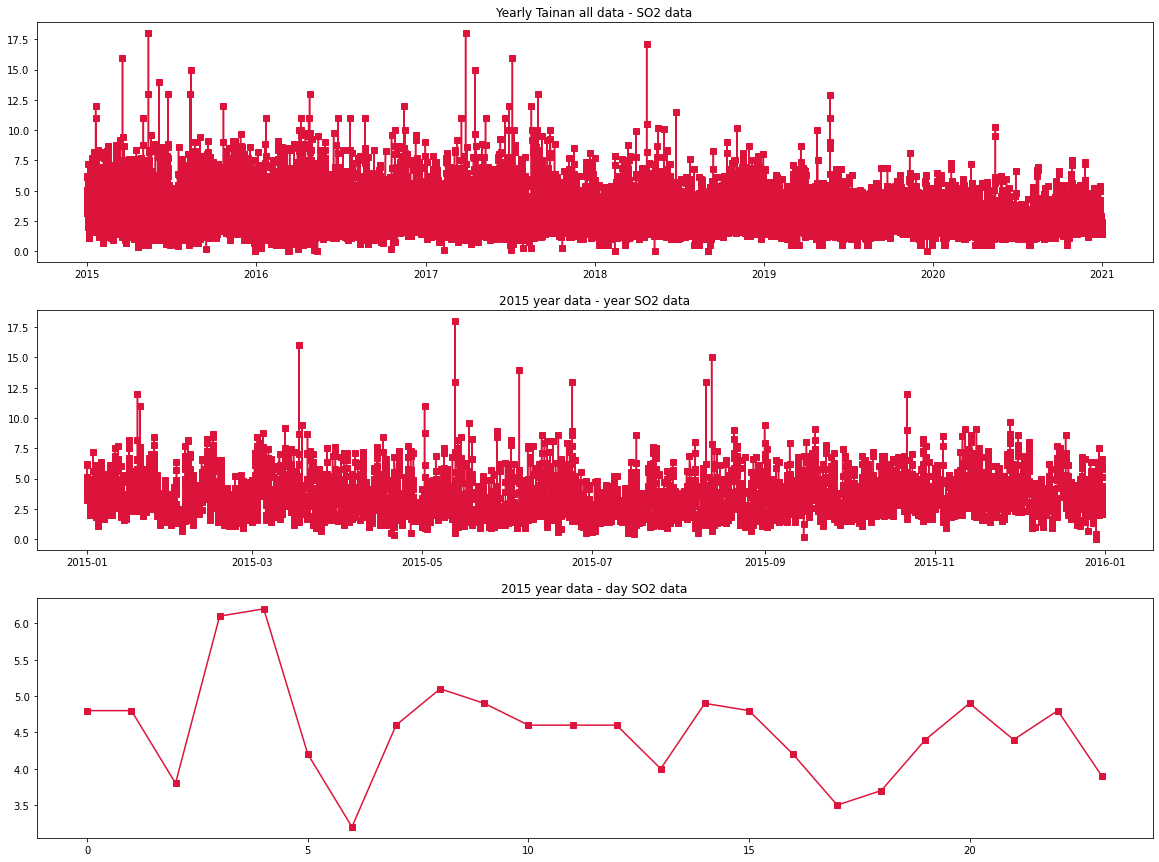

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - SO2 data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["SO2"],'s-',color = '#DC143C')

axs[1].title.set_text('2015 year data - year SO2 data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["SO2"][:365*24],'s-',color = '#DC143C')

axs[2].title.set_text('2015 year data - day SO2 data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["SO2"][:24],'s-',color = '#DC143C')

## THC 數據檢視與處理

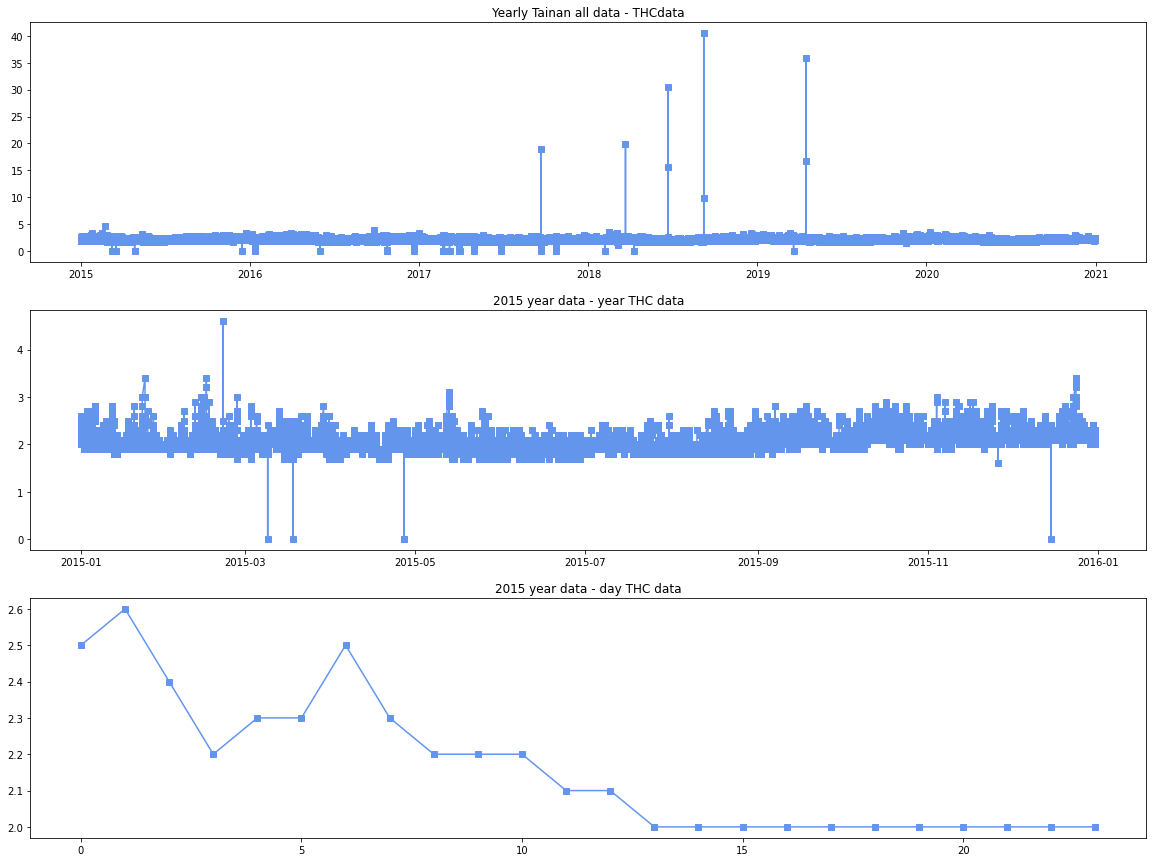

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - THCdata')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["THC"],'s-',color = '#6495ED')

axs[1].title.set_text('2015 year data - year THC data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["THC"][:365*24],'s-',color = '#6495ED')

axs[2].title.set_text('2015 year data - day THC data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["THC"][:24],'s-',color = '#6495ED')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["THC"] > 8]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
23845,2017/09/20,臺南,13,35.000000,1.800,0.38,0.070,0.05,4.3,4.3,42.000000,49.0,25.0,0.0,44.0,1.85,19.000000,322.0,328.0,3.4,2.9
28236,2018/03/22,臺南,12,23.299999,1.885,0.31,0.110,1.40,5.5,6.9,64.000000,36.0,19.0,0.0,45.0,1.70,19.900000,262.0,247.0,2.0,1.8
30444,2018/06/22,臺南,12,29.500000,1.450,0.18,0.045,2.70,3.9,6.6,27.700001,31.0,5.0,0.0,81.0,1.90,30.500000,216.0,215.0,3.8,2.9
30445,2018/06/22,臺南,13,27.900000,1.200,0.16,0.045,3.10,4.7,7.7,21.299999,25.0,6.0,0.8,89.0,1.30,15.600000,183.0,160.0,1.8,1.8
32293,2018/09/07,臺南,13,31.700001,1.750,0.16,8.120,3.00,2.8,5.7,61.500000,40.0,26.0,0.0,74.0,0.50,9.900000,247.0,247.0,3.5,3.1
32294,2018/09/07,臺南,14,31.500000,1.750,0.20,4.095,3.10,3.6,6.7,33.400002,37.0,25.0,0.0,74.0,1.40,40.500000,251.0,253.0,3.0,3.0
37595,2019/04/16,臺南,11,23.500000,1.955,0.55,0.240,4.50,21.5,26.0,7.350000,55.0,33.0,0.0,86.0,2.40,35.939999,337.0,2.0,0.5,1.6
37596,2019/04/16,臺南,12,24.700001,1.955,0.51,0.240,3.10,17.4,20.5,0.000000,1000.0,33.0,0.0,82.0,2.50,16.730000,344.0,347.0,1.9,1.6


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["THC"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
15877,2016/10/23,臺南,13,31.0,1.7,0.27,0.06,1.600,4.600,6.200,31.0,15.0,14.0,0.0,58.0,2.4,-0.1,297.0,303.0,3.2,1.5
15878,2016/10/23,臺南,14,31.0,1.7,0.29,0.06,1.900,4.800,6.600,29.0,17.0,10.0,0.0,57.0,2.5,-0.1,282.0,290.0,3.4,2.9
15879,2016/10/23,臺南,15,30.0,1.7,0.29,0.06,1.400,3.600,5.000,29.0,12.0,10.0,0.0,62.0,1.9,-0.1,280.0,282.0,3.2,3.1
15880,2016/10/23,臺南,16,29.0,1.7,0.34,0.06,1.400,5.600,7.100,27.0,24.0,13.0,0.0,68.0,1.9,-0.1,293.0,318.0,2.9,2.0
15881,2016/10/23,臺南,17,29.0,1.7,0.41,0.06,1.000,7.900,8.900,22.0,22.0,19.0,0.0,72.0,2.0,-0.1,307.0,316.0,2.5,1.6
15882,2016/10/23,臺南,18,28.0,1.7,0.44,0.06,0.800,7.900,8.700,21.0,28.0,13.0,0.0,74.0,2.0,-0.1,320.0,320.0,2.2,0.9
15883,2016/10/23,臺南,19,28.0,1.7,0.39,0.06,0.900,7.400,8.300,19.0,19.0,12.0,0.0,74.0,2.0,-0.1,357.0,313.0,2.0,0.9
15884,2016/10/23,臺南,20,28.0,1.7,0.41,0.06,0.800,7.000,7.800,20.0,20.0,12.0,0.0,76.0,2.0,-0.1,323.0,301.0,1.9,0.7
15885,2016/10/23,臺南,21,28.0,1.7,0.42,0.06,0.600,7.500,8.100,20.0,16.0,14.0,0.0,76.0,1.9,-0.1,1.2,35.0,1.4,0.5
15886,2016/10/23,臺南,22,27.0,1.7,0.45,0.06,0.500,6.800,7.300,21.0,20.0,13.0,0.0,78.0,2.0,-0.1,322.0,311.0,1.8,1.2


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["THC"] > 8, "THC"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["THC"] < 0.0, "THC"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["THC"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

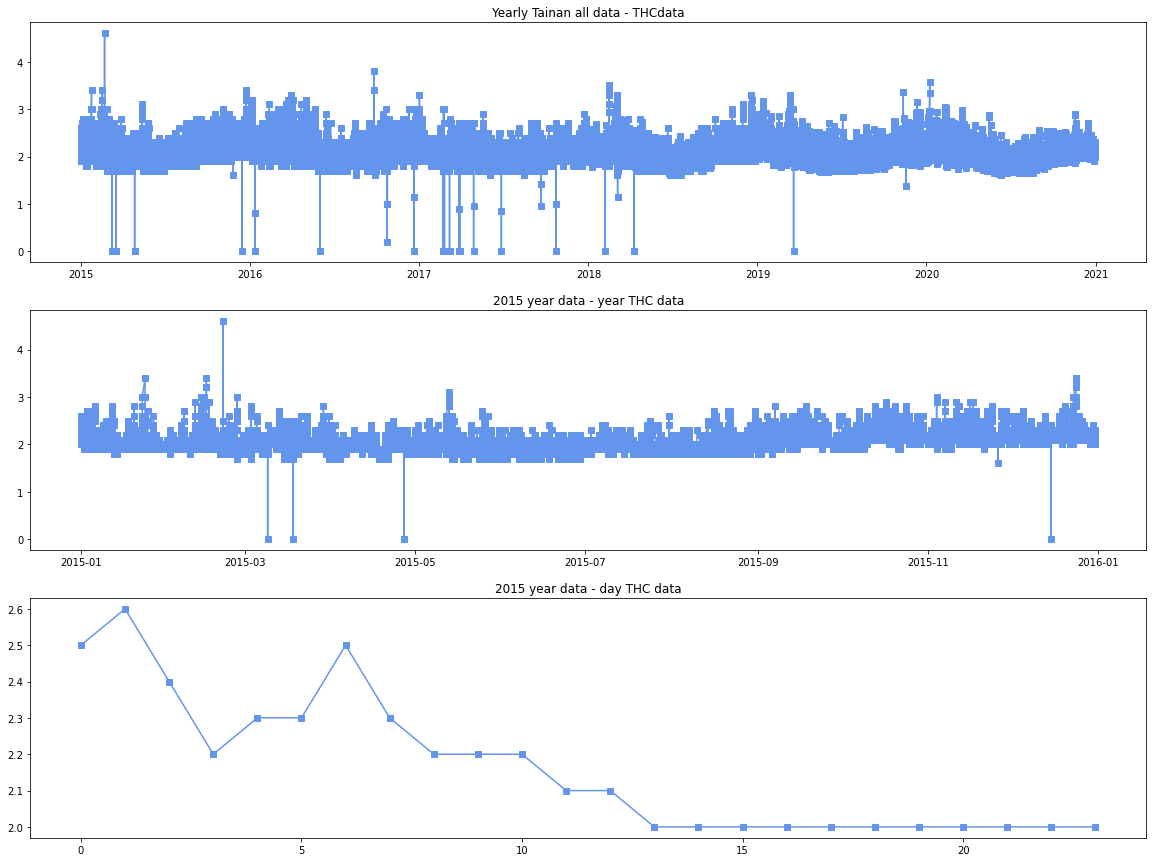

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - THCdata')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["THC"],'s-',color = '#6495ED')

axs[1].title.set_text('2015 year data - year THC data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["THC"][:365*24],'s-',color = '#6495ED')

axs[2].title.set_text('2015 year data - day THC data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["THC"][:24],'s-',color = '#6495ED')

## WD_HR 數據檢視與處理

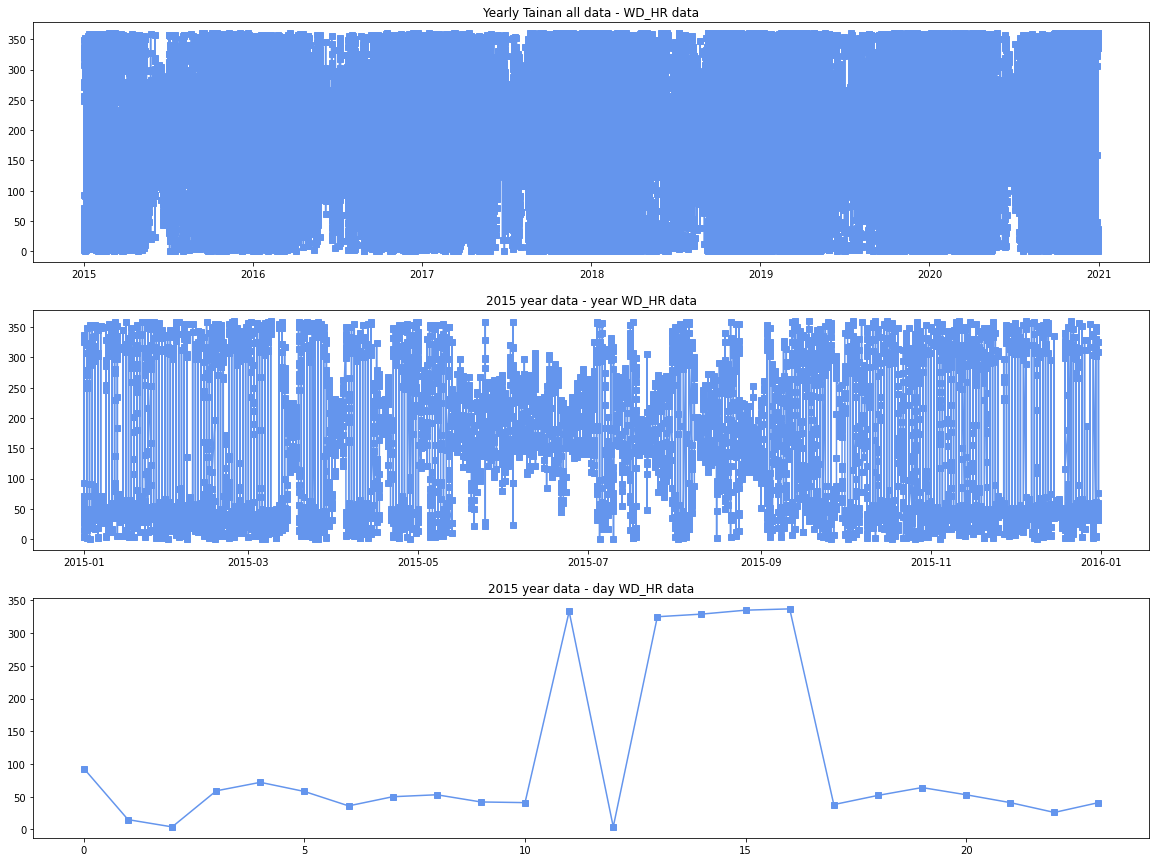

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - WD_HR data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["WD_HR"],'s-',color = '#6495ED')

axs[1].title.set_text('2015 year data - year WD_HR data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["WD_HR"][:365*24],'s-',color = '#6495ED')

axs[2].title.set_text('2015 year data - day WD_HR data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["WD_HR"][:24],'s-',color = '#6495ED')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WD_HR"] > 360]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WD_HR"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


無離群值

## WIND_DIREC 數據檢視與處理

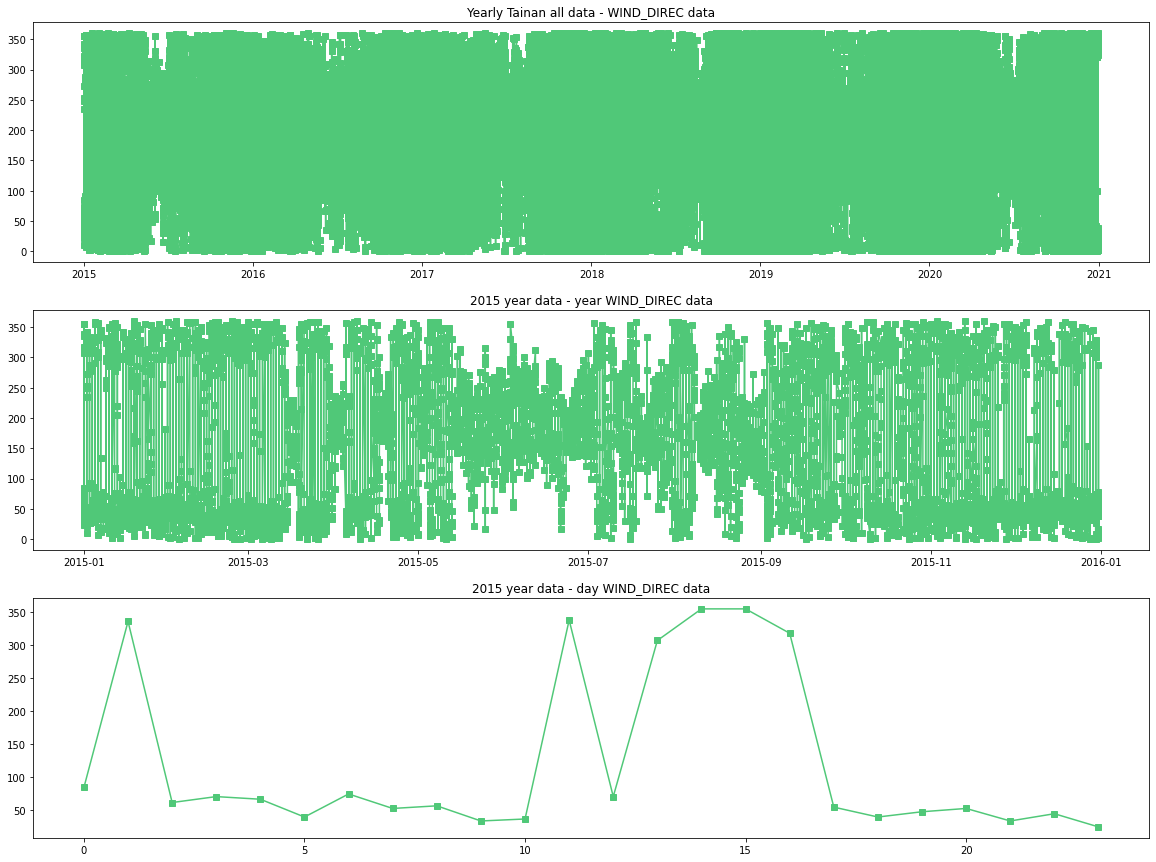

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - WIND_DIREC data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["WIND_DIREC"],'s-',color = '#50C878')

axs[1].title.set_text('2015 year data - year WIND_DIREC data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["WIND_DIREC"][:365*24],'s-',color = '#50C878')

axs[2].title.set_text('2015 year data - day WIND_DIREC data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["WIND_DIREC"][:24],'s-',color = '#50C878')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WIND_DIREC"] > 360]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WIND_DIREC"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


無離群值

## WIND_SPEED 數據檢視與處理

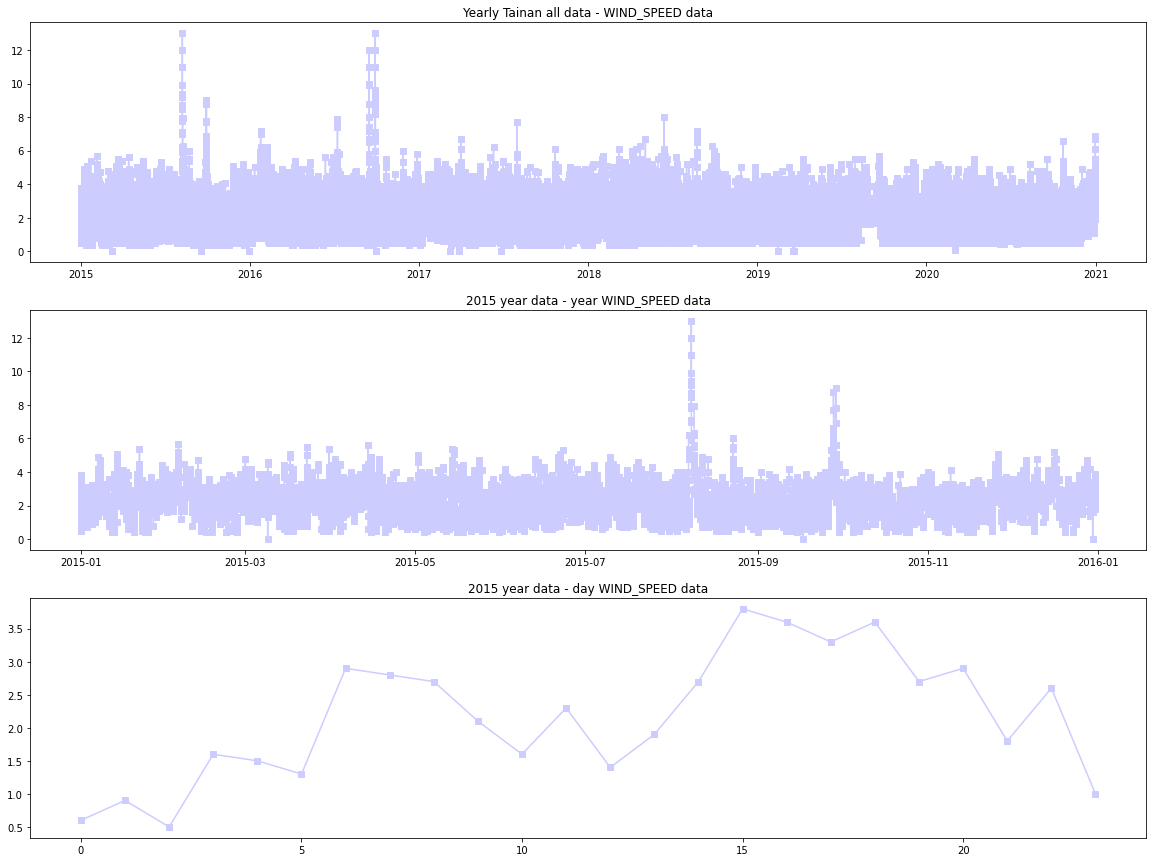

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - WIND_SPEED data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["WIND_SPEED"],'s-',color = '#CCCCFF')

axs[1].title.set_text('2015 year data - year WIND_SPEED data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["WIND_SPEED"][:365*24],'s-',color = '#CCCCFF')

axs[2].title.set_text('2015 year data - day WIND_SPEED data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["WIND_SPEED"][:24],'s-',color = '#CCCCFF')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WIND_SPEED"] > 13]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WIND_SPEED"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


無離群值

## WIND_SPEED 數據檢視與處理

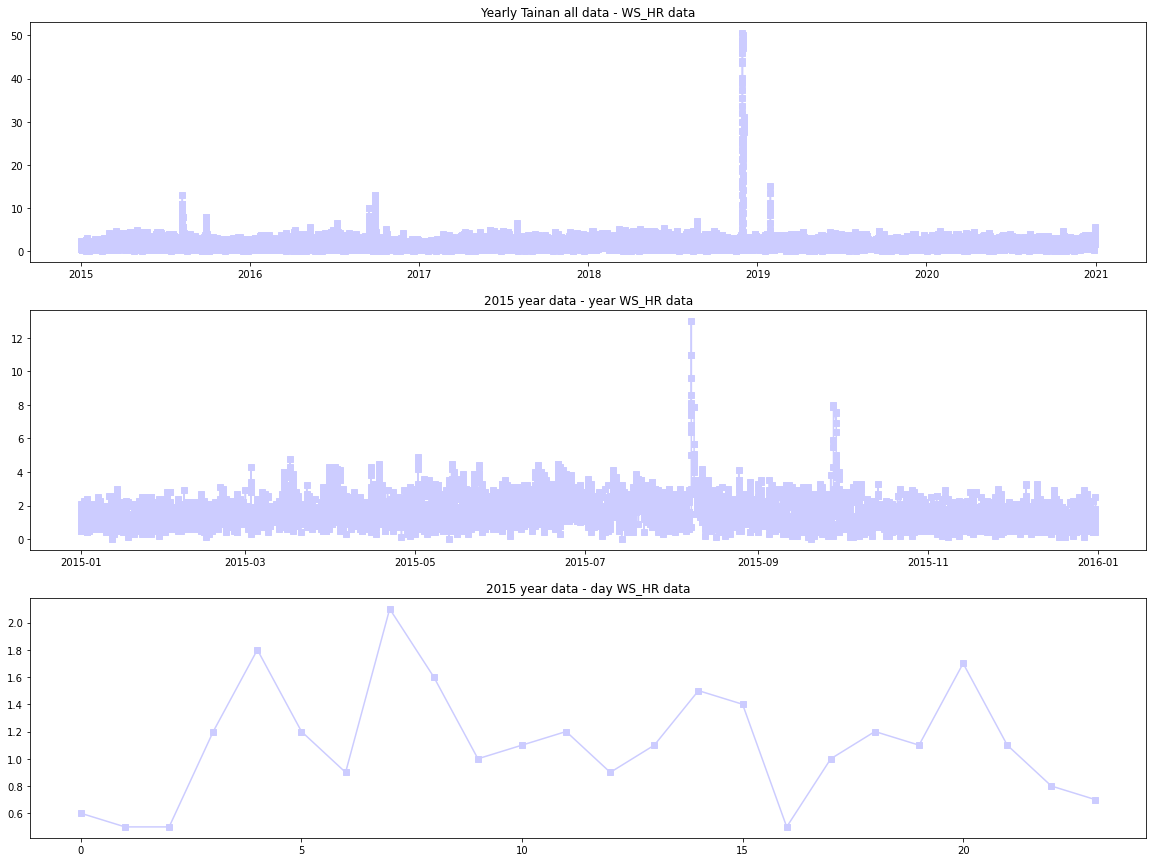

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - WS_HR data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["WS_HR"],'s-',color = '#CCCCFF')

axs[1].title.set_text('2015 year data - year WS_HR data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["WS_HR"][:365*24],'s-',color = '#CCCCFF')

axs[2].title.set_text('2015 year data - day WS_HR data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["WS_HR"][:24],'s-',color = '#CCCCFF')

In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WS_HR"] > 13]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
34273,2018/11/29,臺南,1,20.799999,1.90,0.32,0.13,1.100000,14.300000,15.400000,18.500000,45.0,20.0,0.0,79.0,2.7,2.10,18.0,19.0,2.1,14.800000
34274,2018/11/29,臺南,2,20.500000,2.00,0.34,0.13,1.000000,15.900000,17.000000,15.600000,50.0,21.0,0.0,81.0,2.6,2.10,20.0,21.0,2.1,16.400000
34275,2018/11/29,臺南,3,20.500000,2.00,0.35,0.14,1.000000,15.800000,16.799999,14.000000,49.0,25.0,0.0,80.0,2.6,2.20,21.0,22.0,2.1,18.500000
34276,2018/11/29,臺南,4,20.200001,2.00,0.35,0.13,1.100000,16.100000,17.200001,15.900000,47.0,28.0,0.0,80.0,3.2,2.10,22.0,23.0,2.0,19.400000
34277,2018/11/29,臺南,5,20.100000,2.00,0.33,0.13,1.100000,16.799999,17.900000,14.200000,47.0,24.0,0.0,80.0,2.8,2.10,21.0,22.0,2.1,21.400000
34278,2018/11/29,臺南,6,19.900000,2.00,0.35,0.13,1.300000,16.600000,17.799999,14.700000,50.0,21.0,0.0,81.0,2.4,2.10,20.0,21.0,2.1,23.500000
34279,2018/11/29,臺南,7,20.299999,2.00,0.63,0.25,5.500000,23.100000,28.600000,9.000000,56.0,17.0,0.0,80.0,3.1,2.30,22.0,22.0,2.1,25.000000
34280,2018/11/29,臺南,8,21.100000,2.10,0.83,0.32,15.000000,28.100000,43.099998,8.400000,68.0,25.0,0.0,79.0,3.9,2.40,22.0,23.0,2.0,26.100000
34281,2018/11/29,臺南,9,22.500000,2.00,0.62,0.30,12.000000,23.299999,35.299999,17.500000,66.0,32.0,0.0,74.0,3.5,2.30,21.0,21.0,2.1,27.900000
34282,2018/11/29,臺南,10,23.700001,2.00,0.46,0.22,6.100000,17.600000,23.700001,29.799999,63.0,36.0,0.0,70.0,2.5,2.20,20.0,20.0,2.1,29.900000


In [ ]:
tn_dataset_cleaned[tn_dataset_cleaned["WS_HR"] < 0]

,日期,測站,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR


處理離群值

In [ ]:
tn_dataset_cleaned.loc[tn_dataset_cleaned["WS_HR"] > 8, "WS_HR"] = np.nan
tn_dataset_cleaned.loc[tn_dataset_cleaned["WS_HR"] < 0.0, "WS_HR"] = np.nan

tn_dataset_nanf = tn_dataset_cleaned.fillna(method='ffill')
tn_dataset_nanb = tn_dataset_cleaned.fillna(method='bfill')
clean_list = ["WS_HR"]
tn_dataset_cleaned[clean_list] = (tn_dataset_nanf[clean_list].astype("float32") + tn_dataset_nanb[clean_list].astype("float32"))/2

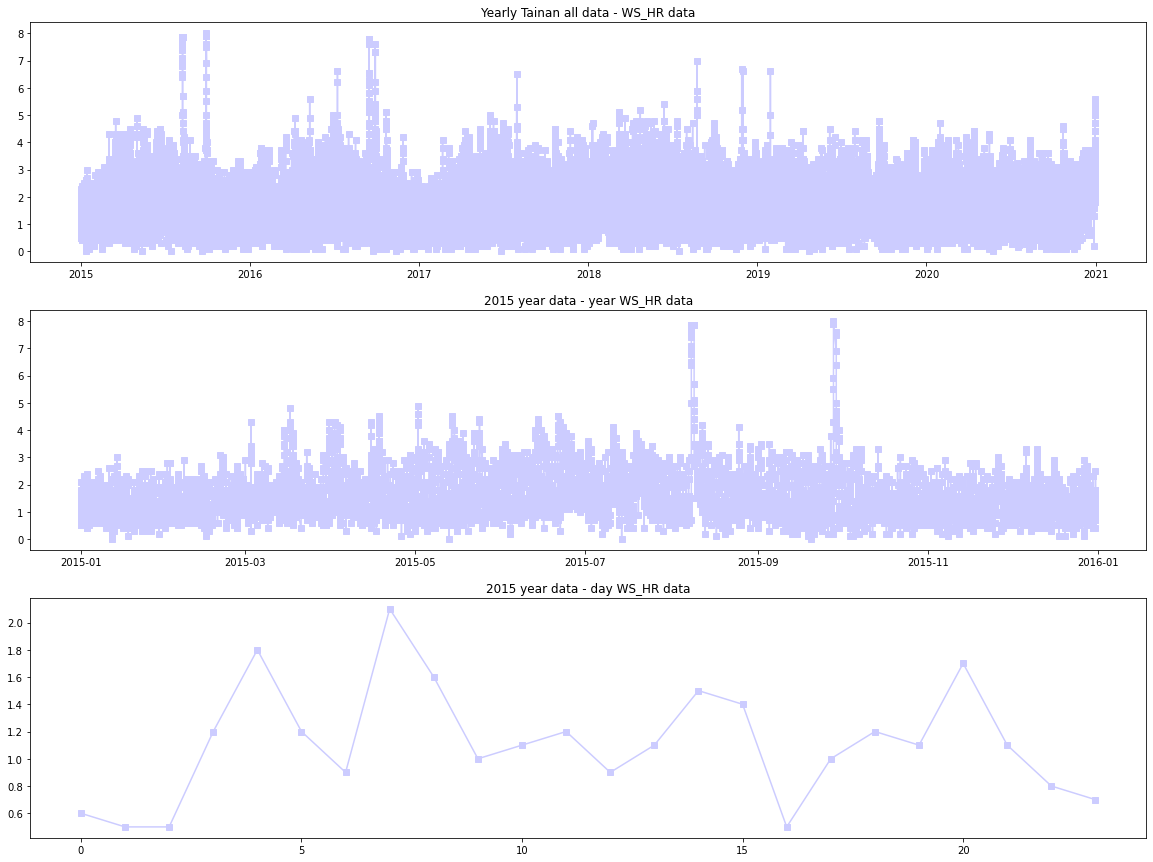

In [ ]:
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(20)

axs[0].title.set_text('Yearly Tainan all data - WS_HR data')
axs[0].plot(tn_dataset_cleaned["日期"].astype('datetime64'),tn_dataset_cleaned["WS_HR"],'s-',color = '#CCCCFF')

axs[1].title.set_text('2015 year data - year WS_HR data')
axs[1].plot(tn_dataset_cleaned["日期"][:365*24].astype('datetime64'),tn_dataset_cleaned["WS_HR"][:365*24],'s-',color = '#CCCCFF')

axs[2].title.set_text('2015 year data - day WS_HR data')
axs[2].plot(tn_dataset_cleaned["timing"][:24],tn_dataset_cleaned["WS_HR"][:24],'s-',color = '#CCCCFF')

# 相關係數

In [ ]:
tn_dataset_cleaned.corr()

,timing,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
timing,1.000000,0.126968,-0.298357,0.092876,-0.047223,-0.104678,-0.013210,-0.042335,0.243814,0.036393,-0.014427,-0.007224,-0.185019,-0.135982,-0.212440,0.170977,0.141235,0.134317,0.120869
AMB_TEMP,0.126968,1.000000,-0.471261,-0.492159,-0.307140,-0.165095,-0.574275,-0.531166,0.222344,-0.198165,-0.158581,0.007190,-0.239517,-0.053059,-0.444770,0.530540,0.500408,-0.035845,0.080666
CH4,-0.298357,-0.471261,1.000000,0.609374,0.569398,0.285061,0.654163,0.635631,-0.152617,0.250503,0.228758,-0.080723,0.213272,0.366249,0.889074,-0.395634,-0.355086,-0.287867,-0.319005
CO,0.092876,-0.492159,0.609374,1.000000,0.729246,0.460456,0.839044,0.842251,-0.022780,0.314774,0.271486,-0.080022,0.022962,0.407642,0.737851,-0.275860,-0.246565,-0.186909,-0.324292
NMHC,-0.047223,-0.307140,0.569398,0.729246,1.000000,0.469626,0.772418,0.788985,-0.229459,0.201987,0.194809,-0.056475,0.117234,0.404928,0.767636,-0.258335,-0.226615,-0.303304,-0.365326
NO,-0.104678,-0.165095,0.285061,0.460456,0.469626,1.000000,0.406210,0.640225,-0.227380,0.079522,0.083433,-0.019348,0.057882,0.281017,0.408115,-0.122381,-0.083700,-0.060122,-0.078894
NO2,-0.013210,-0.574275,0.654163,0.839044,0.772418,0.406210,1.000000,0.959323,-0.280169,0.269237,0.232261,-0.071259,0.164490,0.466694,0.788178,-0.406196,-0.368274,-0.282763,-0.365538
NOx,-0.042335,-0.531166,0.635631,0.842251,0.788985,0.640225,0.959323,1.000000,-0.303261,0.249543,0.219502,-0.065747,0.155952,0.475677,0.784997,-0.377819,-0.334369,-0.254959,-0.329912
O3,0.243814,0.222344,-0.152617,-0.022780,-0.229459,-0.227380,-0.280169,-0.303261,1.000000,0.179871,0.128096,-0.032073,-0.576352,0.019415,-0.209814,0.403365,0.371061,0.273558,0.170883
PM10,0.036393,-0.198165,0.250503,0.314774,0.201987,0.079522,0.269237,0.249543,0.179871,1.000000,0.720114,-0.048018,-0.121711,0.192577,0.251817,-0.062311,-0.060368,0.040413,-0.026688


# 類神經模型建置

## 資料集建置

### 特徵工程

timing, WD_HR, weekday, month

In [ ]:
tn_dataset_cleaned['weekday'] = 'weekday_' + (tn_dataset_cleaned['日期'].astype('datetime64').dt.weekday +1).astype('str')
tn_dataset_cleaned['month'] = 'month_' + (tn_dataset_cleaned['日期'].astype('datetime64').dt.month).astype('str')
tn_dataset_cleaned['timing'] = "hour_" + tn_dataset_cleaned['timing'].astype('str')

In [ ]:
direction = []

for i in tn_dataset_cleaned['WD_HR']:
  if i >= 315 or i < 45:
    direction.append("north")
  elif i >= 45 and i < 135:
    direction.append("east")
  elif i >= 135 and i < 225:
    direction.append("south")
  elif i >= 225 and i < 315:
    direction.append("west")

tn_dataset_cleaned['direction'] = direction

### One hot encoding

In [ ]:
timing_oh_df = pd.get_dummies(tn_dataset_cleaned['timing'])
direction_oh_df = pd.get_dummies(tn_dataset_cleaned['direction'])
weekday_oh_df = pd.get_dummies(tn_dataset_cleaned['weekday'])
month_oh_df = pd.get_dummies(tn_dataset_cleaned['month'])

In [ ]:
training_data_all = pd.concat([tn_dataset_cleaned, timing_oh_df, direction_oh_df, weekday_oh_df, month_oh_df], axis=1)

檢視 one-hot 欄位相關係數

In [ ]:
training_data_all.corr()[["PM2.5"]][-47:]

,PM2.5
hour_0,-0.009134
hour_1,-0.008419
hour_10,0.026542
hour_11,0.048264
hour_12,0.013179
hour_13,0.005638
hour_14,0.050684
hour_15,0.000421
hour_16,-0.016602
hour_17,-0.019505


### 資料欄位選擇


第一組選擇欄位 (所有可使用之資料欄位)

In [ ]:
target_label = ["PM2.5"] # "PM10",
column_selected_1 = ['AMB_TEMP','CH4','CO','NMHC','NO','NO2','NOx','O3','RAINFALL','RH','SO2','THC','WD_HR','WIND_DIREC','WIND_SPEED','WS_HR',
                     'hour_0','hour_1','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_2','hour_20',
                     'hour_21','hour_22','hour_23','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','east','north','south','west',
                     'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weekday_7','month_1','month_10','month_11','month_12','month_2',
                     'month_3','month_4','month_5','month_6','month_7','month_8','month_9']

第二組選擇欄位 (以 correlation 絕對值大於 0.002 作為 threshold)

In [ ]:
temp_corr_df = training_data_all.corr()[["PM2.5"]]

column_selected_2 = [] 

for i in range(len(temp_corr_df)):
  if (abs(temp_corr_df.values[i]) > 0.002) and (temp_corr_df.index[i]!= "PM10") and (temp_corr_df.index[i]!="PM2.5"):
    column_selected_2.append(temp_corr_df.index[i])
column_selected_2

['AMB_TEMP',
 'CH4',
 'CO',
 'NMHC',
 'NO',
 'NO2',
 'NOx',
 'O3',
 'RAINFALL',
 'RH',
 'SO2',
 'THC',
 'WD_HR',
 'WIND_DIREC',
 'WIND_SPEED',
 'WS_HR',
 'hour_0',
 'hour_1',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_2',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'east',
 'north',
 'south',
 'west',
 'weekday_1',
 'weekday_2',
 'weekday_5',
 'weekday_7',
 'month_1',
 'month_10',
 'month_11',
 'month_12',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9']

## Model - (I)

### 資料標準化 - (I)

In [ ]:
scaler_att = MinMaxScaler()
train_scaled_att = scaler_att.fit_transform(training_data_all[column_selected_1]).astype('float32')

scaler_pm25 = MinMaxScaler()
train_scaled_pm25 = scaler_pm25.fit_transform(training_data_all[['PM2.5']]).astype('float32')

### 製作訓練資料集 - (I)

In [ ]:
x_train = []
y_train = []

for i in range(28*24+1, 52608-366*24):
    x_train.append(np.hstack((train_scaled_att[i-28*24:i], train_scaled_pm25[i-28*24-1:i-1])))
    y_train.append(train_scaled_pm25[i-1])

x_train = np.array(x_train,dtype="float32")
y_train = np.array(y_train,dtype="float32")

x_train.shape

(43151, 672, 64)

In [ ]:
x_valid = []
y_valid = []

for i in range(52608-366*24+1,52609):
    x_valid.append(np.hstack((train_scaled_att[i-28*24:i], train_scaled_pm25[i-28*24-1:i-1])))
    y_valid.append(train_scaled_pm25[i-1])

x_valid = np.array(x_valid,dtype="float32")
y_valid = np.array(y_valid,dtype="float32")

x_valid.shape

(8784, 672, 64)

### 模型訓練與建置 - (I)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 64,input_shape = (np.array(x_train).shape[1], np.array(x_train).shape[2]),return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.LSTM(units =64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 672, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 672, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
model.fit(x_train, y_train, epochs = 60, batch_size = 24*30, validation_data=(x_valid, y_valid))

Epoch 1/60
60/60 [==============================] - 14s 189ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 2/60
60/60 [==============================] - 11s 176ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 3/60
60/60 [==============================] - 10s 175ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 4/60
60/60 [==============================] - 11s 176ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 5/60
60/60 [==============================] - 10s 175ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 6/60
60/60 [==============================] - 11s 176ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471

### 模型效度驗證與評估 - (I)

In [ ]:
# 2020 預測 PM2.5 數據
predict_PM25 = model.predict(x_valid)
predict_PM25 = scaler_pm25.inverse_transform(predict_PM25)

# 2020 實際 PM2.5 數據
y_valid_scalback = scaler_pm25.inverse_transform(y_valid)

# 查看 MSE & RMSE
print("MSE: ", (mean_squared_error(y_valid_scalback, predict_PM25)))
print("RMSE: ", np.sqrt(mean_squared_error(y_valid_scalback, predict_PM25)))

MSE:  91.0725
RMSE:  9.543191


## Model - (II)

### 資料標準化 - (II)

In [ ]:
scaler_att_2 = MinMaxScaler()
train_scaled_att_2 = scaler_att_2.fit_transform(training_data_all[column_selected_2]).astype('float32')

scaler_pm25_2 = MinMaxScaler()
train_scaled_pm25_2 = scaler_pm25_2.fit_transform(training_data_all[['PM2.5']]).astype('float32')

### 製作訓練資料集 - (II)

In [ ]:
x_train_2 = []
y_train_2 = []

for i in range(28*24+1, 52608-366*24):
    x_train_2.append(np.hstack((train_scaled_att_2[i-28*24:i], train_scaled_pm25_2[i-28*24-1:i-1])))
    y_train_2.append(train_scaled_pm25_2[i-1])

x_train_2 = np.array(x_train_2,dtype="float32")
y_train_2 = np.array(y_train_2,dtype="float32")

x_train_2.shape

(43151, 672, 60)

In [ ]:
x_valid_2 = []
y_valid_2 = []

for i in range(52608-366*24+1,52609):
    x_valid_2.append(np.hstack((train_scaled_att_2[i-28*24:i], train_scaled_pm25_2[i-28*24-1:i-1])))
    y_valid_2.append(train_scaled_pm25_2[i-1])

x_valid_2 = np.array(x_valid_2,dtype="float32")
y_valid_2 = np.array(y_valid_2,dtype="float32")

x_valid_2.shape

(8784, 672, 60)

### 模型訓練與建置 - (II)

In [ ]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.LSTM(units = 64,input_shape = (np.array(x_train_2).shape[1], np.array(x_train_2).shape[2]),return_sequences=True))
model_2.add(tf.keras.layers.Dropout(0.5))
# model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.LSTM(units =64))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(1, activation='relu'))

model_2.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 672, 64)           32000     
_________________________________________________________________
dropout (Dropout)            (None, 672, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
model_2.fit(x_train_2, y_train_2, epochs = 60, batch_size = 24*30, validation_data=(x_valid_2, y_valid_2))

Epoch 1/60
60/60 [==============================] - 15s 156ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 2/60
60/60 [==============================] - 9s 145ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 3/60
60/60 [==============================] - 9s 145ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 4/60
60/60 [==============================] - 9s 145ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 5/60
60/60 [==============================] - 9s 145ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 4.8711e-04 - val_root_mean_squared_error: 0.0221
Epoch 6/60
60/60 [==============================] - 9s 145ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - va

### 模型效度驗證與評估 - (II)

In [ ]:
# 2020 預測 PM2.5 數據
predict_PM25_2 = model_2.predict(x_valid_2)
predict_PM25_2 = scaler_pm25_2.inverse_transform(predict_PM25_2)

# 2020 實際 PM2.5 數據
y_valid_scalback_2 = scaler_pm25_2.inverse_transform(y_valid_2)

# 查看 MSE & RMSE
print("MSE: ", (mean_squared_error(y_valid_scalback_2, predict_PM25_2)))
print("RMSE: ", np.sqrt(mean_squared_error(y_valid_scalback_2, predict_PM25_2)))

MSE:  53.73302
RMSE:  7.3302813


## Model - (III)

### 資料標準化 - (III)

In [ ]:
column_selected_3 = ['AMB_TEMP','CH4','CO','NMHC','NO','NO2','NOx','O3',"PM10","PM2.5",'RAINFALL','RH','SO2','THC','WD_HR','WIND_DIREC','WIND_SPEED','WS_HR',
                     'hour_0','hour_1','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_2','hour_20',
                     'hour_21','hour_22','hour_23','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','east','north','south','west',
                     'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weekday_7','month_1','month_10','month_11','month_12','month_2',
                     'month_3','month_4','month_5','month_6','month_7','month_8','month_9']

# m3_target_list = ["AMB_TEMP","CH4","CO","NMHC","NO","NO2","NOx","O3","PM10","PM2.5","RAINFALL","RH","SO2","THC","WD_HR","WS_HR"]
m3_target_list = ["PM2.5"]

In [ ]:
scaler_att_3 = MinMaxScaler()
train_scaled_att_3 = scaler_att_3.fit_transform(training_data_all[column_selected_3]).astype('float32')

scaler_pm25_3 = MinMaxScaler()
train_scaled_target_3 = scaler_pm25_3.fit_transform(training_data_all[m3_target_list]).astype('float32')

### 製作訓練資料集 - (III)

In [ ]:
x_train_3 = []
y_train_3 = []

for i in range(28*24, 52608-366*24):
    x_train_3.append(train_scaled_att_3[i-28*24:i])
    y_train_3.append(train_scaled_target_3[i])

x_train_3 = np.array(x_train_3,dtype="float32")
y_train_3 = np.array(y_train_3,dtype="float32")

x_train_3.shape

(43152, 672, 65)

In [ ]:
x_valid_3 = []
y_valid_3 = []

for i in range(52608-366*24,52608):
    x_valid_3.append(train_scaled_att_3[i-28*24:i])
    y_valid_3.append(train_scaled_target_3[i])

x_valid_3 = np.array(x_valid_3,dtype="float32")
y_valid_3 = np.array(y_valid_3,dtype="float32")

x_valid_3.shape

(8784, 672, 65)

### 模型訓練與建置 - (III)

In [ ]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.LSTM(units = 64,input_shape = (np.array(x_train_3).shape[1], np.array(x_train_3).shape[2]),return_sequences=True))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_3.add(tf.keras.layers.LSTM(units =64))
model_3.add(tf.keras.layers.Dropout(0.2))
model_3.add(tf.keras.layers.Dense(32, activation='relu'))
model_3.add(tf.keras.layers.Dropout(0.5))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_3.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 672, 64)           33280     
_________________________________________________________________
dropout_10 (Dropout)         (None, 672, 64)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 672, 128)          8320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)               

In [ ]:
model_3.fit(x_train_3, y_train_3, epochs = 60, batch_size = 24*30, validation_data=(x_valid_3, y_valid_3))

Epoch 1/60
60/60 [==============================] - 69s 226ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 4.7984e-04 - val_root_mean_squared_error: 0.0219
Epoch 2/60
60/60 [==============================] - 13s 210ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 4.8545e-04 - val_root_mean_squared_error: 0.0220
Epoch 3/60
60/60 [==============================] - 13s 209ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 4.8584e-04 - val_root_mean_squared_error: 0.0220
Epoch 4/60
60/60 [==============================] - 13s 214ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 4.8598e-04 - val_root_mean_squared_error: 0.0220
Epoch 5/60
60/60 [==============================] - 13s 214ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 4.8617e-04 - val_root_mean_squared_error: 0.0220
Epoch 6/60
60/60 [==============================] - 13s 213ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474

### 模型效度驗證與評估 - (III)

In [ ]:
# 2020 預測 全部 數據
predict_all_3 = model_3.predict(x_valid_3)
predict_all_3 = scaler_pm25_3.inverse_transform(predict_all_3)

# 2020 實際 全部 數據
y_valid_scalback_3 = scaler_pm25_3.inverse_transform(y_valid_3)

# 查看 MSE & RMSE
print("ALL MSE: ", (mean_squared_error(y_valid_scalback_3, predict_all_3)))
print("ALL RMSE: ", np.sqrt(mean_squared_error(y_valid_scalback_3, predict_all_3)))
# print("PM2.5 MSE: ", (mean_squared_error(y_valid_scalback_3[:,9], predict_all_3[:,9])))
# print("PM2.5 RMSE: ", np.sqrt(mean_squared_error(y_valid_scalback_3[:,9], predict_all_3[:,9])))

ALL MSE:  228.54263
ALL RMSE:  15.117626
